In [978]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.special import expit
from sklearn.metrics import roc_auc_score
import random
import tqdm
import optuna

In [979]:
import sys
import importlib
sys.path.append('/home/ec2-user/SageMaker/Bias/')
import fairness
# importlib.reload(fairness.xgb_classifier)

In [368]:
# from fairness.data_simulation import DataGenerator
from fairness.split_data import perform_train_test_split
# from fairness.models import Encoder, Predictor, Adversary
from fairness.init_networks import initialize_networks
from fairness.data_loaders import create_dataloaders
from fairness.training_components import initialize_training_components
# from fairness.train import train_model
from fairness.plots import plot_lines,plot_comparison_heatmaps, plot_auc_roc_curve
from fairness.test import get_transformed_features, get_predictions
from fairness.eval import evaluate_classifier
from fairness.fairness_metrics import get_demographic_parity
from fairness.MI import calculate_MI
from fairness.xgb_classifier import train_xgb_classifier
from fairness.xgb_optuna import objective

In [369]:
def joint_entropies(data, nbins=None):
    n_variables = data.shape[-1]
    n_samples = data.shape[0]
    if nbins == None:
        nbins = int((n_samples/5)**.5)
    histograms2d = np.zeros((n_variables, n_variables, nbins, nbins))
    for i in range(n_variables):
        for j in range(n_variables):
            histograms2d[i,j] = np.histogram2d(data[:,i], data[:,j], bins=nbins)[0]
    probs = histograms2d / len(data) + 1e-100
    joint_entropies = -(probs * np.log2(probs)).sum((2,3))
    return joint_entropies

def mutual_info_matrix(df, nbins=None, normalized=True):
    data = df.to_numpy()
    n_variables = data.shape[-1]
    j_entropies = joint_entropies(data, nbins)
    entropies = j_entropies.diagonal()
    entropies_tile = np.tile(entropies, (n_variables, 1))
    sum_entropies = entropies_tile + entropies_tile.T
    mi_matrix = sum_entropies - j_entropies
    if normalized:
        mi_matrix = mi_matrix * 2 / sum_entropies    
    return pd.DataFrame(mi_matrix, index=df.columns, columns=df.columns)

In [370]:
def generate_simulated_data(n, d, num_non_sensitive, num_sensitive, subset_size, num, binary, seed):
    data = []

    if seed:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)  # If using GPU

    thresholds = np.round(np.random.uniform(0.1, 0.9, num_sensitive), 2)
#     coefficients = np.array([0.5, -0.3, 1.2, 0.7, -0.8])
    coefficients = np.random.randn(d)

    subsets = []
    for _ in range(d):
        subset = np.random.choice(num, subset_size, replace=False)
        subsets.append(subset)

    quadratic_functions = []
    for subset in subsets:
        a = np.random.randn(len(subset))  # coefficients for squares
        cross_terms = np.random.randn(len(subset) * (len(subset) - 1) // 2)  # cross terms coefficients
        quadratic_functions.append((a, cross_terms, subset))

    subsets_y = []
    for _ in range(d):
        subset = np.random.choice(num, subset_size, replace=False)
        subsets_y.append(subset)

    quadratic_functions_y = []
    for subset in subsets_y:
        a = np.random.randn(len(subset))  # coefficients for squares
        cross_terms = np.random.randn(len(subset) * (len(subset) - 1) // 2)  # cross terms coefficients
        quadratic_functions_y.append((a, cross_terms, subset))

    for _ in tqdm.tqdm(range(n)):
        X = np.random.normal(0, 1, num)
                        
        def evaluate_quadratic(X, a, cross_terms, subset):
            result = 0
            # quadratic terms: a_i * X_i^2
            for i, idx in enumerate(subset):
                result += a[i] * X[idx]**2
            
            # cross terms: a_ij * X_i * X_j for i < j
            idx = 0
            for i in range(len(subset)):
                for j in range(i + 1, len(subset)):
                    result += cross_terms[idx] * X[subset[i]] * X[subset[j]]
                    idx += 1
            
            return result
        
        function_values = []
        for (a, cross_terms, subset) in quadratic_functions:
            func_val = evaluate_quadratic(X, a, cross_terms, subset)
            function_values.append(func_val)
        
#         print(X)
#         break
        binary_vars = []
        for i in range(num_sensitive):
            threshold = thresholds[i]
            binary_value = 1 if function_values[num_non_sensitive + i] >= threshold else 0
            binary_vars.append(binary_value)

        function_values_y = []
        for (a, cross_terms, subset) in quadratic_functions_y:
            func_val = evaluate_quadratic(X, a, cross_terms, subset)
            function_values_y.append(func_val)

        linear_combination = np.dot(function_values_y, coefficients)
        probability = 1 / (1 + np.exp(-linear_combination))
        y = 1 if probability > 0.5 else 0


        row = function_values[:num_non_sensitive] + binary_vars + [y]
        data.append(row)
        
    column_names = [f"X{i+1}" for i in range(num_non_sensitive)] + [f"S{i+1}" for i in range(num_sensitive)] + ["Y"]
    df = pd.DataFrame(data, columns=column_names)
    return df

In [371]:
num_non_sensitive = 4
num_sensitive = 1
binary = num_sensitive + 1
d = num_non_sensitive + num_sensitive + 1
num = 4
subset_size = 2
n = 10000
seed = 69

data = generate_simulated_data(n, d, num_non_sensitive, num_sensitive, subset_size, num, binary, seed)
print(data.head())

100%|██████████| 10000/10000 [00:00<00:00, 11390.82it/s]


         X1        X2        X3        X4  S1  Y
0  0.132689  0.198091 -0.176781 -0.047388   0  1
1  2.884844 -0.491054 -0.010165 -1.776016   1  1
2  0.488059  1.031786 -0.101411 -0.078521   0  1
3  2.842068 -1.463188  0.261192 -0.494718   0  1
4  2.090066 -2.606464  0.023429 -0.170081   1  0


In [ ]:
data.shape

In [ ]:
# plt.figure(figsize=(8,8))
sns.heatmap(mutual_info_matrix(data), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('MI Matrix')
plt.show()

In [373]:
num_sensitive = 1
num_non_sensitive = 4
data_train, data_val, data_test = perform_train_test_split(data, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, test_size=0.15, val_size=0.1,random_state=69)

print(data_train.shape, data_val.shape, data_test.shape)

(7499, 6) (1001, 6) (1500, 6)


In [973]:
X_train, Y_train = data_train[['X1', 'X2', 'X3', 'X4']], data_train[['Y']]
X_test, Y_test = data_test[['X1', 'X2', 'X3', 'X4']], data_test[['Y']]
model_before = train_xgb_classifier(X_train, Y_train, seed=42)

Y_pred = model_before.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_before.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.8828794119620529


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:59:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [974]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, X_test, Y_train, Y_test), n_trials=100)

[I 2024-12-04 14:00:06,985] A new study created in memory with name: no-name-c13fa6b3-9b5e-43a2-8bf5-7bb8491f9a89
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  '

Trial 0:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09784393851529478, 'n_estimators': 252, 'subsample': 0.8939227139818415, 'colsample_bytree': 0.9785907361396982, 'gamma': 0.027027841518296902, 'min_child_weight': 8}
Accuracy: 0.8126666666666666, Precision: 0.8612132352941176, Recall: 0.8781630740393627, F1-score: 0.8696055684454757, AUC: 0.8822798591375531
--------------------------------------------------
Trial 1:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.10570813477231016, 'n_estimators': 212, 'subsample': 0.8340032904681011, 'colsample_bytree': 0.7694611348046093, 'gamma': 0.4092931377246202, 'min_child_weight': 4}
Accuracy: 0.8113333333333334, Precision: 0.8475177304964538, Recall: 0.8959700093720713, F1-score: 0.8710706150341686, AUC: 0.8776782370982509
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 2:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.029038034567461447, 'n_estimators': 119, 'subsample': 0.7584053582257915, 'colsample_bytree': 0.8734201141406561, 'gamma': 0.3544945721836886, 'min_child_weight': 3}
Accuracy: 0.792, Precision: 0.8212765957446808, Recall: 0.9044048734770385, F1-score: 0.8608385370205174, AUC: 0.8603821121142137
--------------------------------------------------
Trial 3:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.030454435407794113, 'n_estimators': 141, 'subsample': 0.8674589405616058, 'colsample_bytree': 0.7793978788948749, 'gamma': 0.3295325959948593, 'min_child_weight': 1}
Accuracy: 0.7833333333333333, Precision: 0.8170940170940171, Recall: 0.8959700093720713, F1-score: 0.8547161376843988, AUC: 0.8550023700734397
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 4:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.018233215001516936, 'n_estimators': 195, 'subsample': 0.994104843922538, 'colsample_bytree': 0.7011206901702441, 'gamma': 0.12665963954743154, 'min_child_weight': 5}
Accuracy: 0.7673333333333333, Precision: 0.7817896389324961, Recall: 0.9334582942830365, F1-score: 0.8509184109354977, AUC: 0.8260982963609091
--------------------------------------------------


[I 2024-12-04 14:00:08,090] Trial 5 finished with value: 0.8661482085924361 and parameters: {'max_depth': 6, 'learning_rate': 0.03920896817906924, 'n_estimators': 133, 'subsample': 0.7147397358215364, 'colsample_bytree': 0.9679926052687087, 'gamma': 0.4571158817504338, 'min_child_weight': 8}. Best is trial 0 with value: 0.8822798591375531.
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/Sage

Trial 5:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.03920896817906924, 'n_estimators': 133, 'subsample': 0.7147397358215364, 'colsample_bytree': 0.9679926052687087, 'gamma': 0.4571158817504338, 'min_child_weight': 8}
Accuracy: 0.796, Precision: 0.8364279398762158, Recall: 0.8865979381443299, F1-score: 0.8607825295723385, AUC: 0.8661482085924361
--------------------------------------------------
Trial 6:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.06431416603797593, 'n_estimators': 140, 'subsample': 0.7600788695287974, 'colsample_bytree': 0.8090061144013825, 'gamma': 0.19955376193435592, 'min_child_weight': 4}
Accuracy: 0.786, Precision: 0.8118729096989966, Recall: 0.9100281162136832, F1-score: 0.8581528943879806, AUC: 0.8481702816599606
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 7:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.06866657464914654, 'n_estimators': 389, 'subsample': 0.8930822124383193, 'colsample_bytree': 0.9090353217863132, 'gamma': 0.23838758242246227, 'min_child_weight': 6}
Accuracy: 0.806, Precision: 0.848294434470377, Recall: 0.8856607310215557, F1-score: 0.8665749656121046, AUC: 0.8802560977985372
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 8:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.15785677186677746, 'n_estimators': 299, 'subsample': 0.7371385438174198, 'colsample_bytree': 0.7451064119402778, 'gamma': 0.15049648232386592, 'min_child_weight': 3}
Accuracy: 0.7966666666666666, Precision: 0.8426258992805755, Recall: 0.8781630740393627, F1-score: 0.8600275355667738, AUC: 0.863669912621128
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 9:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.13286114061176235, 'n_estimators': 317, 'subsample': 0.9616199025319068, 'colsample_bytree': 0.7129021204861852, 'gamma': 0.13403791132920923, 'min_child_weight': 7}
Accuracy: 0.796, Precision: 0.8437217705510388, Recall: 0.8753514526710403, F1-score: 0.859245630174793, AUC: 0.8633387516747438
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 10:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.22063360541644447, 'n_estimators': 488, 'subsample': 0.9207518406411045, 'colsample_bytree': 0.9853003530446809, 'gamma': 0.00137448181139882, 'min_child_weight': 9}
Accuracy: 0.8053333333333333, Precision: 0.8571428571428571, Recall: 0.8716026241799437, F1-score: 0.8643122676579925, AUC: 0.8778037752347888
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 11:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.07292106057045825, 'n_estimators': 392, 'subsample': 0.8876259452638121, 'colsample_bytree': 0.9108031365856004, 'gamma': 0.0073401787804177054, 'min_child_weight': 10}
Accuracy: 0.8046666666666666, Precision: 0.8518181818181818, Recall: 0.8781630740393627, F1-score: 0.8647900323027227, AUC: 0.8813578031691887
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 12:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010658321835734513, 'n_estimators': 389, 'subsample': 0.8181142412473505, 'colsample_bytree': 0.927452860416819, 'gamma': 0.014852520227242025, 'min_child_weight': 10}
Accuracy: 0.7893333333333333, Precision: 0.8251082251082251, Recall: 0.8931583880037488, F1-score: 0.8577857785778578, AUC: 0.8616894402947115
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 13:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.2946530495486354, 'n_estimators': 293, 'subsample': 0.9231052058232577, 'colsample_bytree': 0.9397619049192611, 'gamma': 0.07399416748334253, 'min_child_weight': 10}
Accuracy: 0.8146666666666667, Precision: 0.865616311399444, Recall: 0.8753514526710403, F1-score: 0.8704566635601119, AUC: 0.8834335113233235
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 14:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.2507517555702752, 'n_estimators': 267, 'subsample': 0.9435309927969922, 'colsample_bytree': 0.9470455638505786, 'gamma': 0.09330496910914512, 'min_child_weight': 8}
Accuracy: 0.8033333333333333, Precision: 0.849005424954792, Recall: 0.880037488284911, F1-score: 0.8642429820524621, AUC: 0.8803426758237358
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 15:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.28653380900280084, 'n_estimators': 244, 'subsample': 0.815012058895152, 'colsample_bytree': 0.9985798850324797, 'gamma': 0.06916052488019041, 'min_child_weight': 8}
Accuracy: 0.8126666666666666, Precision: 0.8645640074211502, Recall: 0.8734770384254921, F1-score: 0.868997668997669, AUC: 0.8816759774117933
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 16:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.11016887652436853, 'n_estimators': 331, 'subsample': 0.9186905007514835, 'colsample_bytree': 0.8735297045972933, 'gamma': 0.0737582373274312, 'min_child_weight': 10}
Accuracy: 0.81, Precision: 0.8561020036429873, Recall: 0.8809746954076851, F1-score: 0.8683602771362586, AUC: 0.8822668724337732
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 17:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.17072757731476917, 'n_estimators': 211, 'subsample': 0.9820554044395553, 'colsample_bytree': 0.8434985249321314, 'gamma': 0.18872648790628904, 'min_child_weight': 7}
Accuracy: 0.81, Precision: 0.8574040219378428, Recall: 0.8791002811621368, F1-score: 0.8681166126793152, AUC: 0.8838902104062457
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 18:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.18290548747279353, 'n_estimators': 185, 'subsample': 0.9918642974495916, 'colsample_bytree': 0.8293843908447494, 'gamma': 0.2783119185697198, 'min_child_weight': 6}
Accuracy: 0.8066666666666666, Precision: 0.854147675478578, Recall: 0.8781630740393627, F1-score: 0.865988909426987, AUC: 0.8803470047249957
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 19:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.28586515160376413, 'n_estimators': 362, 'subsample': 0.9608546381877066, 'colsample_bytree': 0.8654975919836927, 'gamma': 0.20652918684360416, 'min_child_weight': 7}
Accuracy: 0.802, Precision: 0.8538602941176471, Recall: 0.8706654170571696, F1-score: 0.8621809744779583, AUC: 0.8812236072301309
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 20:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.16829245361426373, 'n_estimators': 217, 'subsample': 0.9369655219028699, 'colsample_bytree': 0.8179049971077099, 'gamma': 0.17583254057407824, 'min_child_weight': 9}
Accuracy: 0.806, Precision: 0.8559633027522936, Recall: 0.8744142455482662, F1-score: 0.8650904033379694, AUC: 0.8807171257827193
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 21:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09490952644505864, 'n_estimators': 266, 'subsample': 0.8926947988251598, 'colsample_bytree': 0.9559066280981419, 'gamma': 0.06091657974477357, 'min_child_weight': 9}
Accuracy: 0.8073333333333333, Precision: 0.858195211786372, Recall: 0.8734770384254921, F1-score: 0.8657686948444031, AUC: 0.8811673315137518
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 22:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1830450166344086, 'n_estimators': 283, 'subsample': 0.9755470305082333, 'colsample_bytree': 0.90459313072049, 'gamma': 0.11385593710100161, 'min_child_weight': 7}
Accuracy: 0.8093333333333333, Precision: 0.8585858585858586, Recall: 0.8762886597938144, F1-score: 0.8673469387755102, AUC: 0.8823512860083418
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 23:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.21563222477133276, 'n_estimators': 290, 'subsample': 0.9728207025995916, 'colsample_bytree': 0.8943278523541874, 'gamma': 0.10967493871501646, 'min_child_weight': 7}
Accuracy: 0.808, Precision: 0.8589861751152074, Recall: 0.8734770384254921, F1-score: 0.8661710037174721, AUC: 0.8832322174147369
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 24:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.2152469411055183, 'n_estimators': 337, 'subsample': 0.9999234961374339, 'colsample_bytree': 0.8452252927484045, 'gamma': 0.2621969300528018, 'min_child_weight': 5}
Accuracy: 0.8066666666666666, Precision: 0.8509485094850948, Recall: 0.8828491096532334, F1-score: 0.8666053357865685, AUC: 0.8797972342649849
--------------------------------------------------
Trial 25:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.13285260725590564, 'n_estimators': 175, 'subsample': 0.948812330562694, 'colsample_bytree': 0.8855434008271743, 'gamma': 0.17210080838750413, 'min_child_weight': 6}
Accuracy: 0.806, Precision: 0.8495495495495495, Recall: 0.8837863167760075, F1-score: 0.8663298116674323, AUC: 0.8804573917071239
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 26:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.29446764536365494, 'n_estimators': 469, 'subsample': 0.9180909118256181, 'colsample_bytree': 0.9339941745780339, 'gamma': 0.2193669514619998, 'min_child_weight': 7}
Accuracy: 0.8013333333333333, Precision: 0.8524289642529789, Recall: 0.8716026241799437, F1-score: 0.8619091751621872, AUC: 0.8803405113731058
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 27:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.22105550725739553, 'n_estimators': 228, 'subsample': 0.9743066450496474, 'colsample_bytree': 0.8544758861658123, 'gamma': 0.04864949122512405, 'min_child_weight': 9}
Accuracy: 0.8093333333333333, Precision: 0.8585858585858586, Recall: 0.8762886597938144, F1-score: 0.8673469387755102, AUC: 0.8843772117979873
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 28:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.13847022422034386, 'n_estimators': 236, 'subsample': 0.861978191114927, 'colsample_bytree': 0.7919121683406848, 'gamma': 0.05547738193509172, 'min_child_weight': 9}
Accuracy: 0.8053333333333333, Precision: 0.8525932666060054, Recall: 0.8781630740393627, F1-score: 0.8651892890120036, AUC: 0.8837873990013225
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 29:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.08652267260086548, 'n_estimators': 243, 'subsample': 0.791167236508937, 'colsample_bytree': 0.7900208837620587, 'gamma': 0.03303787083244325, 'min_child_weight': 9}
Accuracy: 0.8053333333333333, Precision: 0.8426171529619806, Recall: 0.8931583880037488, F1-score: 0.8671519563239308, AUC: 0.8748514645755188
--------------------------------------------------
Trial 30:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04843164619871759, 'n_estimators': 159, 'subsample': 0.8526778612462048, 'colsample_bytree': 0.8444843035458564, 'gamma': 0.2961575399215267, 'min_child_weight': 8}
Accuracy: 0.8053333333333333, Precision: 0.8450578806767587, Recall: 0.8894095595126523, F1-score: 0.8666666666666667, AUC: 0.8740008354779432
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 31:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.1359241206375944, 'n_estimators': 240, 'subsample': 0.8698792478072809, 'colsample_bytree': 0.7945954074401534, 'gamma': 0.05303072441140645, 'min_child_weight': 10}
Accuracy: 0.8006666666666666, Precision: 0.8490909090909091, Recall: 0.8753514526710403, F1-score: 0.862021227503461, AUC: 0.8801673553227088
--------------------------------------------------
Trial 32:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.21561549899302515, 'n_estimators': 100, 'subsample': 0.9314164369892057, 'colsample_bytree': 0.7573048781864045, 'gamma': 0.09308448448441752, 'min_child_weight': 9}
Accuracy: 0.798, Precision: 0.8429084380610413, Recall: 0.880037488284911, F1-score: 0.8610729023383769, AUC: 0.8735679453519505
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 33:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.1510936239885849, 'n_estimators': 216, 'subsample': 0.9774400272332465, 'colsample_bytree': 0.7379891753587444, 'gamma': 0.03410318496441336, 'min_child_weight': 10}
Accuracy: 0.7906666666666666, Precision: 0.834072759538598, Recall: 0.8809746954076851, F1-score: 0.8568824065633546, AUC: 0.8656417271450247
--------------------------------------------------
Trial 34:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.11175087616925532, 'n_estimators': 213, 'subsample': 0.9103203687122128, 'colsample_bytree': 0.8326248147187504, 'gamma': 0.1679359162784252, 'min_child_weight': 8}
Accuracy: 0.8033333333333333, Precision: 0.8452593917710197, Recall: 0.8856607310215557, F1-score: 0.8649885583524027, AUC: 0.8768113746209507
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 35:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.18529130812640768, 'n_estimators': 266, 'subsample': 0.9519515218800437, 'colsample_bytree': 0.859510211489882, 'gamma': 0.37395539636507413, 'min_child_weight': 9}
Accuracy: 0.806, Precision: 0.8527272727272728, Recall: 0.8791002811621368, F1-score: 0.8657129672358099, AUC: 0.8819508626417987
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 36:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.23866853407861544, 'n_estimators': 229, 'subsample': 0.8763637448105797, 'colsample_bytree': 0.7738986014001785, 'gamma': 0.04313719226058474, 'min_child_weight': 10}
Accuracy: 0.8066666666666666, Precision: 0.8607242339832869, Recall: 0.8687910028116214, F1-score: 0.8647388059701493, AUC: 0.8843750473473575
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 37:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.12358347383754338, 'n_estimators': 191, 'subsample': 0.8530650874077799, 'colsample_bytree': 0.7717274474651806, 'gamma': 0.03490836997046747, 'min_child_weight': 8}
Accuracy: 0.8133333333333334, Precision: 0.8554652213188798, Recall: 0.887535145267104, F1-score: 0.8712051517939282, AUC: 0.8825655666207082
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 38:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08585378746316148, 'n_estimators': 161, 'subsample': 0.8303483828215199, 'colsample_bytree': 0.813802671641541, 'gamma': 0.41789401263485926, 'min_child_weight': 2}
Accuracy: 0.8033333333333333, Precision: 0.8452593917710197, Recall: 0.8856607310215557, F1-score: 0.8649885583524027, AUC: 0.8793188906757632
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 39:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.024858715752420272, 'n_estimators': 232, 'subsample': 0.7746088694880213, 'colsample_bytree': 0.7956659175978503, 'gamma': 0.14979708663781768, 'min_child_weight': 9}
Accuracy: 0.7946666666666666, Precision: 0.8314410480349345, Recall: 0.8922211808809747, F1-score: 0.8607594936708861, AUC: 0.8668278460902445
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 40:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.24104246645912414, 'n_estimators': 203, 'subsample': 0.8728279537121183, 'colsample_bytree': 0.7518788045152941, 'gamma': 0.32820644688422546, 'min_child_weight': 9}
Accuracy: 0.8046666666666666, Precision: 0.8583333333333333, Recall: 0.8687910028116214, F1-score: 0.8635305076851421, AUC: 0.8803946226388549
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 41:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.26215446804019243, 'n_estimators': 269, 'subsample': 0.9037239008036205, 'colsample_bytree': 0.7253347301347677, 'gamma': 0.08741205504610812, 'min_child_weight': 10}
Accuracy: 0.7973333333333333, Precision: 0.8427672955974843, Recall: 0.8791002811621368, F1-score: 0.8605504587155963, AUC: 0.8671655003885188
--------------------------------------------------
Trial 42:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.19935595161956218, 'n_estimators': 228, 'subsample': 0.8375693385755889, 'colsample_bytree': 0.7777374850657011, 'gamma': 0.04858443116823111, 'min_child_weight': 10}
Accuracy: 0.808, Precision: 0.8443854995579133, Recall: 0.895032802249297, F1-score: 0.8689717925386715, AUC: 0.8761090103915274
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 43:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.1547872038010884, 'n_estimators': 311, 'subsample': 0.8876324170284982, 'colsample_bytree': 0.8060113982344245, 'gamma': 0.12738543496899946, 'min_child_weight': 10}
Accuracy: 0.814, Precision: 0.8601462522851919, Recall: 0.8819119025304593, F1-score: 0.8708931050439611, AUC: 0.8839399927707349
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 44:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.14926111899374928, 'n_estimators': 315, 'subsample': 0.8719876823445281, 'colsample_bytree': 0.8033429428123153, 'gamma': 0.1279095578719501, 'min_child_weight': 5}
Accuracy: 0.8173333333333334, Precision: 0.8654377880184332, Recall: 0.880037488284911, F1-score: 0.8726765799256505, AUC: 0.8807625792459488
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 45:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.1607087368944945, 'n_estimators': 360, 'subsample': 0.8814613686156599, 'colsample_bytree': 0.8257060021072428, 'gamma': 0.14078489344470702, 'min_child_weight': 8}
Accuracy: 0.8106666666666666, Precision: 0.8614958448753463, Recall: 0.8744142455482662, F1-score: 0.867906976744186, AUC: 0.8820482629201469
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 46:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.12315799319527539, 'n_estimators': 176, 'subsample': 0.8001249929978067, 'colsample_bytree': 0.7636640351887132, 'gamma': 0.001822754802678593, 'min_child_weight': 9}
Accuracy: 0.8046666666666666, Precision: 0.8486486486486486, Recall: 0.8828491096532334, F1-score: 0.8654111162149747, AUC: 0.8815417814727355
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 47:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04512710309535153, 'n_estimators': 251, 'subsample': 0.857683316714221, 'colsample_bytree': 0.7841308747832263, 'gamma': 0.09697114091417056, 'min_child_weight': 10}
Accuracy: 0.8066666666666666, Precision: 0.8471849865951743, Recall: 0.8884723523898782, F1-score: 0.8673376029277219, AUC: 0.8755570754808869
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 48:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.0722876524980211, 'n_estimators': 427, 'subsample': 0.8407407443841574, 'colsample_bytree': 0.8521991097171314, 'gamma': 0.11563246152552484, 'min_child_weight': 8}
Accuracy: 0.8033333333333333, Precision: 0.8452593917710197, Recall: 0.8856607310215557, F1-score: 0.8649885583524027, AUC: 0.8799498280343974
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 49:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.012410556366592182, 'n_estimators': 310, 'subsample': 0.9878362579806031, 'colsample_bytree': 0.8367507950597048, 'gamma': 0.1971258579937514, 'min_child_weight': 4}
Accuracy: 0.79, Precision: 0.8224699828473413, Recall: 0.8987816307403936, F1-score: 0.8589341692789969, AUC: 0.8622976509217312
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 50:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.06241916853731613, 'n_estimators': 204, 'subsample': 0.8981935781491888, 'colsample_bytree': 0.802157259476874, 'gamma': 0.022142078835317693, 'min_child_weight': 1}
Accuracy: 0.804, Precision: 0.8399296394019349, Recall: 0.895032802249297, F1-score: 0.8666061705989111, AUC: 0.8749218092209926
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 51:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.24251744413009155, 'n_estimators': 292, 'subsample': 0.9331416709506579, 'colsample_bytree': 0.8744956860848568, 'gamma': 0.07083611063200693, 'min_child_weight': 10}
Accuracy: 0.8153333333333334, Precision: 0.8623853211009175, Recall: 0.8809746954076851, F1-score: 0.8715808993973111, AUC: 0.8823382993045621
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 52:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.26092870561310255, 'n_estimators': 277, 'subsample': 0.9648788838520508, 'colsample_bytree': 0.8158326211890643, 'gamma': 0.08133748666489696, 'min_child_weight': 10}
Accuracy: 0.816, Precision: 0.8651892890120036, Recall: 0.8781630740393627, F1-score: 0.8716279069767442, AUC: 0.8858793405351821
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 53:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.17718046820166233, 'n_estimators': 277, 'subsample': 0.9613397003282775, 'colsample_bytree': 0.8145374255056956, 'gamma': 0.4966736230250412, 'min_child_weight': 9}
Accuracy: 0.812, Precision: 0.8604224058769513, Recall: 0.8781630740393627, F1-score: 0.8692022263450835, AUC: 0.8819422048392787
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 54:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.24920996847585533, 'n_estimators': 254, 'subsample': 0.9795352546466849, 'colsample_bytree': 0.8224192022124336, 'gamma': 0.04867806238311365, 'min_child_weight': 10}
Accuracy: 0.82, Precision: 0.8686401480111008, Recall: 0.880037488284911, F1-score: 0.8743016759776536, AUC: 0.8832949864830059
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 55:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.19630656500750285, 'n_estimators': 230, 'subsample': 0.8857981777121838, 'colsample_bytree': 0.7775540910746698, 'gamma': 0.2392331173433841, 'min_child_weight': 9}
Accuracy: 0.8093333333333333, Precision: 0.8585858585858586, Recall: 0.8762886597938144, F1-score: 0.8673469387755102, AUC: 0.8817062797206128
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 56:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1456302726583804, 'n_estimators': 336, 'subsample': 0.9677990869124009, 'colsample_bytree': 0.805458482134339, 'gamma': 0.08130280199947262, 'min_child_weight': 10}
Accuracy: 0.8093333333333333, Precision: 0.859245630174793, Recall: 0.8753514526710403, F1-score: 0.8672237697307336, AUC: 0.8836196540775003
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 57:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.22308331158387817, 'n_estimators': 304, 'subsample': 0.7053510788560293, 'colsample_bytree': 0.8562001549290352, 'gamma': 0.15987324869731614, 'min_child_weight': 10}
Accuracy: 0.8013333333333333, Precision: 0.8576744186046512, Recall: 0.8641049671977507, F1-score: 0.8608776844070962, AUC: 0.879734465196716
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 58:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.26582768489504144, 'n_estimators': 255, 'subsample': 0.98384559114189, 'colsample_bytree': 0.8380168598258002, 'gamma': 0.1876013613860606, 'min_child_weight': 9}
Accuracy: 0.8146666666666667, Precision: 0.8602739726027397, Recall: 0.8828491096532334, F1-score: 0.8714153561517114, AUC: 0.8825958689295277
--------------------------------------------------
Trial 59:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.16203894872250874, 'n_estimators': 152, 'subsample': 0.8241481420182339, 'colsample_bytree': 0.7380187609302935, 'gamma': 0.10308318133713301, 'min_child_weight': 7}
Accuracy: 0.8006666666666666, Precision: 0.8440860215053764, Recall: 0.8828491096532334, F1-score: 0.8630325240494732, AUC: 0.8615660666088037
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 60:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.10184154410405481, 'n_estimators': 194, 'subsample': 0.9548059401822797, 'colsample_bytree': 0.883231562800548, 'gamma': 0.12435181864405642, 'min_child_weight': 10}
Accuracy: 0.7893333333333333, Precision: 0.8251082251082251, Recall: 0.8931583880037488, F1-score: 0.8577857785778578, AUC: 0.8627543500046535
--------------------------------------------------


[I 2024-12-04 14:00:23,904] Trial 61 finished with value: 0.8849139955542183 and parameters: {'max_depth': 6, 'learning_rate': 0.13848934993886164, 'n_estimators': 338, 'subsample': 0.9687741627577829, 'colsample_bytree': 0.8070878456534797, 'gamma': 0.07807593515739077, 'min_child_weight': 10}. Best is trial 52 with value: 0.8858793405351821.


Trial 61:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.13848934993886164, 'n_estimators': 338, 'subsample': 0.9687741627577829, 'colsample_bytree': 0.8070878456534797, 'gamma': 0.07807593515739077, 'min_child_weight': 10}
Accuracy: 0.81, Precision: 0.8587155963302753, Recall: 0.8772258669165885, F1-score: 0.8678720445062587, AUC: 0.8849139955542183
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 62:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11766056953647973, 'n_estimators': 356, 'subsample': 0.999252233616035, 'colsample_bytree': 0.7880312968363841, 'gamma': 0.06771780350896986, 'min_child_weight': 10}
Accuracy: 0.81, Precision: 0.8587155963302753, Recall: 0.8772258669165885, F1-score: 0.8678720445062587, AUC: 0.8852105252905234
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 63:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.20196724443380465, 'n_estimators': 357, 'subsample': 0.9951547941098241, 'colsample_bytree': 0.7670663314892646, 'gamma': 0.01694025391240564, 'min_child_weight': 10}
Accuracy: 0.81, Precision: 0.862708719851577, Recall: 0.8716026241799437, F1-score: 0.8671328671328671, AUC: 0.883580693966161
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 64:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1721902319871994, 'n_estimators': 376, 'subsample': 0.9422299875471405, 'colsample_bytree': 0.8219740639915706, 'gamma': 0.06924067590122307, 'min_child_weight': 10}
Accuracy: 0.8013333333333333, Precision: 0.8524289642529789, Recall: 0.8716026241799437, F1-score: 0.8619091751621872, AUC: 0.8839096904619154
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 65:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.12484486656622548, 'n_estimators': 377, 'subsample': 0.9441005629010978, 'colsample_bytree': 0.8203727046539513, 'gamma': 0.06674708145383909, 'min_child_weight': 10}
Accuracy: 0.814, Precision: 0.8634686346863468, Recall: 0.8772258669165885, F1-score: 0.8702928870292888, AUC: 0.8872948912471781
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 66:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0896921799245631, 'n_estimators': 405, 'subsample': 0.9677298820822119, 'colsample_bytree': 0.7863111176732315, 'gamma': 0.04350360127105804, 'min_child_weight': 10}
Accuracy: 0.812, Precision: 0.8597616865261228, Recall: 0.8791002811621368, F1-score: 0.8693234476367007, AUC: 0.8828902342152027
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 67:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11835623377421733, 'n_estimators': 347, 'subsample': 0.9260245353401814, 'colsample_bytree': 0.8093948514467219, 'gamma': 0.08110158966798979, 'min_child_weight': 10}
Accuracy: 0.82, Precision: 0.8666053357865685, Recall: 0.8828491096532334, F1-score: 0.8746518105849582, AUC: 0.8861585546664474
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 68:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11764410531210502, 'n_estimators': 349, 'subsample': 0.9237632442873309, 'colsample_bytree': 0.7964720777201897, 'gamma': 0.08058785759266918, 'min_child_weight': 9}
Accuracy: 0.814, Precision: 0.8621323529411765, Recall: 0.8791002811621368, F1-score: 0.8705336426914153, AUC: 0.8834389224498984
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 69:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.10613761707088297, 'n_estimators': 377, 'subsample': 0.9411611760342596, 'colsample_bytree': 0.8282908689736297, 'gamma': 0.057314413944861795, 'min_child_weight': 10}
Accuracy: 0.816, Precision: 0.8598726114649682, Recall: 0.8856607310215557, F1-score: 0.8725761772853186, AUC: 0.8851023027590252
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 70:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09892701897924652, 'n_estimators': 378, 'subsample': 0.9446486530217688, 'colsample_bytree': 0.8651463277964744, 'gamma': 0.06385575105149793, 'min_child_weight': 9}
Accuracy: 0.8066666666666666, Precision: 0.8574057037718491, Recall: 0.8734770384254921, F1-score: 0.8653667595171773, AUC: 0.8826564735471666
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 71:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07850233516176586, 'n_estimators': 401, 'subsample': 0.9591422429164449, 'colsample_bytree': 0.8129022089849922, 'gamma': 0.019098003244829635, 'min_child_weight': 10}
Accuracy: 0.808, Precision: 0.8570119156736938, Recall: 0.8762886597938144, F1-score: 0.8665430954587581, AUC: 0.8823599438108616
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 72:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.10729504122621489, 'n_estimators': 423, 'subsample': 0.9702753140606835, 'colsample_bytree': 0.8357436778134366, 'gamma': 0.10380088238454699, 'min_child_weight': 10}
Accuracy: 0.8113333333333334, Precision: 0.8596330275229358, Recall: 0.8781630740393627, F1-score: 0.8687992582290218, AUC: 0.88305040356182
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 73:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1320748748013875, 'n_estimators': 327, 'subsample': 0.9281144932813448, 'colsample_bytree': 0.8294852871630214, 'gamma': 0.04146974635292372, 'min_child_weight': 10}
Accuracy: 0.8113333333333334, Precision: 0.8609576427255985, Recall: 0.8762886597938144, F1-score: 0.8685555039479795, AUC: 0.8841586022843612
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 74:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11968673117204033, 'n_estimators': 346, 'subsample': 0.9122608191021055, 'colsample_bytree': 0.8436105923521735, 'gamma': 0.05960730842887616, 'min_child_weight': 9}
Accuracy: 0.8093333333333333, Precision: 0.8605724838411819, Recall: 0.8734770384254921, F1-score: 0.8669767441860465, AUC: 0.8827906694862243
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 75:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06335318429764382, 'n_estimators': 372, 'subsample': 0.9887793854343293, 'colsample_bytree': 0.814878480274801, 'gamma': 0.02642942255541485, 'min_child_weight': 10}
Accuracy: 0.7973333333333333, Precision: 0.8484018264840183, Recall: 0.8706654170571696, F1-score: 0.8593894542090657, AUC: 0.8809476397748106
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 76:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08005864571929115, 'n_estimators': 326, 'subsample': 0.9404051856897234, 'colsample_bytree': 0.7749279118432565, 'gamma': 0.07971199913644612, 'min_child_weight': 10}
Accuracy: 0.8093333333333333, Precision: 0.85662100456621, Recall: 0.8791002811621368, F1-score: 0.8677150786308974, AUC: 0.8827430515723652
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 77:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.22557405771011624, 'n_estimators': 347, 'subsample': 0.9549174579647228, 'colsample_bytree': 0.7849559043331582, 'gamma': 0.0004102209469083046, 'min_child_weight': 9}
Accuracy: 0.81, Precision: 0.8647388059701493, Recall: 0.8687910028116214, F1-score: 0.8667601683029453, AUC: 0.8830698836174896
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 78:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.2827061157935309, 'n_estimators': 422, 'subsample': 0.9965884861374453, 'colsample_bytree': 0.7609970503781015, 'gamma': 0.09073670658893253, 'min_child_weight': 10}
Accuracy: 0.8073333333333333, Precision: 0.8575367647058824, Recall: 0.8744142455482662, F1-score: 0.8658932714617169, AUC: 0.8850698359995757
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 79:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.2746875788997694, 'n_estimators': 476, 'subsample': 0.9982277791150808, 'colsample_bytree': 0.759184774896074, 'gamma': 0.08895526133776072, 'min_child_weight': 10}
Accuracy: 0.814, Precision: 0.865491651205937, Recall: 0.8744142455482662, F1-score: 0.8699300699300699, AUC: 0.8811824826681617
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 80:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09576523326069611, 'n_estimators': 427, 'subsample': 0.9792204008682346, 'colsample_bytree': 0.7981274028543568, 'gamma': 0.11504517014523978, 'min_child_weight': 9}
Accuracy: 0.812, Precision: 0.8610855565777369, Recall: 0.8772258669165885, F1-score: 0.8690807799442897, AUC: 0.8825828822257478
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 81:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.2922105725731341, 'n_estimators': 446, 'subsample': 0.9706794090250074, 'colsample_bytree': 0.8077718292157766, 'gamma': 0.059697341507115025, 'min_child_weight': 10}
Accuracy: 0.8126666666666666, Precision: 0.8645640074211502, Recall: 0.8734770384254921, F1-score: 0.868997668997669, AUC: 0.8813253364097392
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 82:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.03389034130308588, 'n_estimators': 385, 'subsample': 0.9496225235278675, 'colsample_bytree': 0.8225964851948149, 'gamma': 0.04377420894592577, 'min_child_weight': 3}
Accuracy: 0.8046666666666666, Precision: 0.8480215827338129, Recall: 0.8837863167760075, F1-score: 0.8655346489215237, AUC: 0.8820309473151072
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 83:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.2334589424501, 'n_estimators': 399, 'subsample': 0.9645080095182841, 'colsample_bytree': 0.7474139960397549, 'gamma': 0.09406888830325721, 'min_child_weight': 10}
Accuracy: 0.794, Precision: 0.8464351005484461, Recall: 0.8678537956888472, F1-score: 0.8570106432207312, AUC: 0.8661958265062952
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 84:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1955521918874124, 'n_estimators': 368, 'subsample': 0.9934870396723434, 'colsample_bytree': 0.7257409375867542, 'gamma': 0.03143389257996954, 'min_child_weight': 10}
Accuracy: 0.7973333333333333, Precision: 0.8471337579617835, Recall: 0.872539831302718, F1-score: 0.8596491228070176, AUC: 0.8649988853079256
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 85:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.13510857921722513, 'n_estimators': 415, 'subsample': 0.9837558416229177, 'colsample_bytree': 0.8499379674841534, 'gamma': 0.14253367369403452, 'min_child_weight': 9}
Accuracy: 0.8133333333333334, Precision: 0.8600182982616651, Recall: 0.8809746954076851, F1-score: 0.8703703703703703, AUC: 0.8836737653432494
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 86:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.2990052811500499, 'n_estimators': 453, 'subsample': 0.7388409331770464, 'colsample_bytree': 0.7701551983212356, 'gamma': 0.07102038148311018, 'min_child_weight': 10}
Accuracy: 0.8153333333333334, Precision: 0.8623853211009175, Recall: 0.8809746954076851, F1-score: 0.8715808993973111, AUC: 0.8804725428615335
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 87:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11151035560968288, 'n_estimators': 324, 'subsample': 0.9872764913155955, 'colsample_bytree': 0.7898285228980515, 'gamma': 0.05437369197564589, 'min_child_weight': 9}
Accuracy: 0.812, Precision: 0.8604224058769513, Recall: 0.8781630740393627, F1-score: 0.8692022263450835, AUC: 0.8830092789998507
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 88:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.25704041138678146, 'n_estimators': 389, 'subsample': 0.9999627738609586, 'colsample_bytree': 0.8283636197378457, 'gamma': 0.011733297749954366, 'min_child_weight': 10}
Accuracy: 0.81, Precision: 0.860036832412523, Recall: 0.8753514526710403, F1-score: 0.8676265675801208, AUC: 0.8822733657856632
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 89:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.20704990535460716, 'n_estimators': 357, 'subsample': 0.9757042815240661, 'colsample_bytree': 0.7824806477575049, 'gamma': 0.1106900597271318, 'min_child_weight': 10}
Accuracy: 0.814, Precision: 0.8661710037174721, Recall: 0.8734770384254921, F1-score: 0.8698086794213719, AUC: 0.8824768241448797
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 90:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.18051576423636093, 'n_estimators': 298, 'subsample': 0.9333827359697664, 'colsample_bytree': 0.8101531177903948, 'gamma': 0.08620198238201876, 'min_child_weight': 9}
Accuracy: 0.8093333333333333, Precision: 0.8585858585858586, Recall: 0.8762886597938144, F1-score: 0.8673469387755102, AUC: 0.8821521565503851
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 91:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.12811244111406053, 'n_estimators': 340, 'subsample': 0.9273703811318849, 'colsample_bytree': 0.8292469288362951, 'gamma': 0.03862627595104201, 'min_child_weight': 10}
Accuracy: 0.8126666666666666, Precision: 0.8598901098901099, Recall: 0.880037488284911, F1-score: 0.8698471514590088, AUC: 0.8846888926887022
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 92:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1276632341143765, 'n_estimators': 342, 'subsample': 0.9121595734953929, 'colsample_bytree': 0.8217021968505767, 'gamma': 0.03639833674443118, 'min_child_weight': 10}
Accuracy: 0.808, Precision: 0.8576675849403123, Recall: 0.8753514526710403, F1-score: 0.8664192949907236, AUC: 0.8838837170543558
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 93:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.11434315134113218, 'n_estimators': 369, 'subsample': 0.9581291196795139, 'colsample_bytree': 0.8390237862057456, 'gamma': 0.0646060182698927, 'min_child_weight': 10}
Accuracy: 0.804, Precision: 0.8568790397045245, Recall: 0.8697282099343955, F1-score: 0.8632558139534884, AUC: 0.882396739471571
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 94:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09134040617594412, 'n_estimators': 337, 'subsample': 0.9378432495906643, 'colsample_bytree': 0.7983959586080627, 'gamma': 0.05106338011227711, 'min_child_weight': 10}
Accuracy: 0.8053333333333333, Precision: 0.8564857405703772, Recall: 0.872539831302718, F1-score: 0.8644382544103992, AUC: 0.8842018912969605
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 95:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1444308801050692, 'n_estimators': 354, 'subsample': 0.9261715403851689, 'colsample_bytree': 0.8592966624703511, 'gamma': 0.02670068671347823, 'min_child_weight': 10}
Accuracy: 0.8126666666666666, Precision: 0.8632162661737524, Recall: 0.8753514526710403, F1-score: 0.8692415076779898, AUC: 0.8833664133537946
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 96:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.26987894562294945, 'n_estimators': 285, 'subsample': 0.9471399449140155, 'colsample_bytree': 0.7556631885632327, 'gamma': 0.09961414260970838, 'min_child_weight': 9}
Accuracy: 0.8166666666666667, Precision: 0.865988909426987, Recall: 0.8781630740393627, F1-score: 0.8720335039553281, AUC: 0.8825006331018093
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 97:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.10525112350289463, 'n_estimators': 382, 'subsample': 0.9038972851963716, 'colsample_bytree': 0.8317827246575603, 'gamma': 0.07574681677137664, 'min_child_weight': 10}
Accuracy: 0.8093333333333333, Precision: 0.859245630174793, Recall: 0.8753514526710403, F1-score: 0.8672237697307336, AUC: 0.8824140550766107
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 98:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.16747722499069603, 'n_estimators': 320, 'subsample': 0.9164746238661088, 'colsample_bytree': 0.8485129155762499, 'gamma': 0.04020156711203764, 'min_child_weight': 9}
Accuracy: 0.8146666666666667, Precision: 0.8635944700460829, Recall: 0.8781630740393627, F1-score: 0.870817843866171, AUC: 0.8835179248978919
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 99:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.14240853927049593, 'n_estimators': 364, 'subsample': 0.951654165877593, 'colsample_bytree': 0.8160244488985458, 'gamma': 0.009956469372352283, 'min_child_weight': 6}
Accuracy: 0.8093333333333333, Precision: 0.853393665158371, Recall: 0.8837863167760075, F1-score: 0.8683241252302025, AUC: 0.883407537915764
--------------------------------------------------


In [975]:
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.12484486656622548, 'n_estimators': 377, 'subsample': 0.9441005629010978, 'colsample_bytree': 0.8203727046539513, 'gamma': 0.06674708145383909, 'min_child_weight': 10}


In [976]:
import xgboost as xgb
model_before = xgb.XGBClassifier(**best_params, eval_metric='logloss', random_state=42)
model_before.fit(X_train, Y_train)

Y_pred = model_after.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_after.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.8846867282380722


In [977]:
metrics_before = evaluate_classifier(Y_test, Y_pred, Y_probs[:, 1])

for metric, value in metrics_before.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.8107
Precision: 0.8595
Recall: 0.8772
F1 Score: 0.8683
ROC AUC Score: 0.8847


In [376]:
all_group_stats_before, all_demographic_parity_before = get_demographic_parity(Y_test, Y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats_before.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity_before.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 924                   787                  0.851732
1                 576                   309                  0.536458



Demographic parity for sensitive variable: S1
0.3152732683982684


In [377]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, Y_train = data_train[['X1', 'X2', 'X3', 'X4']], data_train[['Y']]
X_test, Y_test = data_test[['X1', 'X2', 'X3', 'X4']], data_test[['Y']]

model = LogisticRegression()
model.fit(X_train, Y_train.to_numpy().reshape(-1))
Y_pred = model.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model.predict_proba(X_test)
roc_auc_score(Y_test,Y_probs[:,1]) 

0.8611613143410005

In [378]:
metrics = evaluate_classifier(Y_test, Y_pred, Y_probs[:,1])

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.7800
Precision: 0.8038
Recall: 0.9138
F1 Score: 0.8553
ROC AUC Score: 0.8612


In [379]:
all_group_stats, all_demographic_parity = get_demographic_parity(Y_test, Y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 924                   836                  0.904762
1                 576                   377                  0.654514



Demographic parity for sensitive variable: S1
0.2502480158730159


In [849]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, input_dim - 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


    
class Predictor(nn.Module):
    def __init__(self, input_dim):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)


class Adversary(nn.Module):
    def __init__(self, input_dim):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [857]:
encoder, predictor, adversaries = initialize_networks(Encoder, Predictor, Adversary, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive)

train_loader, val_loader, test_loader = create_dataloaders(train_df=data_train, test_df=data_test, val_df=data_val, batch_size=512, shuffle_train=True)

criterion_enc, criterion_pred, criterion_adversaries, optimizer_enc, optimizer_pred, optimizer_adversaries = initialize_training_components(encoder, predictor, adversaries, learning_rate=0.0001)

In [859]:
epochs_total = []
gradient_norms_enc = []
gradient_norms_pred = []
gradient_norms_adversaryA = []
gradient_norms_adversaryB = []

loss_enc = []
loss_pred = []
loss_adversaryA = []
loss_adversaryB = []
loss_comb = []

loss_enc_valid = []
loss_pred_valid = []
loss_adversaryA_valid = []
loss_adversaryB_valid = []
loss_comb_valid = []

In [860]:
num_epochs = 10000
encoder, predictor, adversaries, curr_epochs_total, curr_gradient_norms_enc, curr_gradient_norms_pred, curr_gradient_norms_adversaries, curr_loss_enc, curr_loss_pred, curr_loss_adversaries, curr_loss_comb, curr_loss_enc_valid, curr_loss_pred_valid, curr_loss_adversaries_valid, curr_loss_comb_valid = train_model(encoder=encoder, predictor=predictor, adversaries=adversaries, num_epochs=num_epochs, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, 
                train_dataloader=train_loader, val_dataloader=val_loader, criterion_enc=criterion_enc, criterion_pred=criterion_pred, criterion_adversaries=criterion_adversaries, 
                optimizer_enc=optimizer_enc, optimizer_pred=optimizer_pred, optimizer_adversaries=optimizer_adversaries)

Model saved at epoch 1 with pearson corr 0.3067
Epoch [1/10000], Val Loss Adversary 0 : 0.7039, Val Loss Recon: 5.4109, Val Loss P: 0.7441, Val Loss Comb: -0.8838, Val Corr Coeff: 0.3067
Val loss did not improve. Patience [1/1000]. Epoch [2/10000], Val Loss Adversary 0 : 0.6936, Val Loss Recon: 5.3741, Val Loss P: 0.7429, Val Loss Comb: -0.8185, Val Corr Coeff: 0.3112
Val loss did not improve. Patience [2/1000]. Epoch [3/10000], Val Loss Adversary 0 : 0.6842, Val Loss Recon: 5.3368, Val Loss P: 0.7417, Val Loss Comb: -0.7639, Val Corr Coeff: 0.3156
Val loss did not improve. Patience [3/1000]. Epoch [4/10000], Val Loss Adversary 0 : 0.6751, Val Loss Recon: 5.2995, Val Loss P: 0.7404, Val Loss Comb: -0.7113, Val Corr Coeff: 0.3196
Val loss did not improve. Patience [4/1000]. Epoch [5/10000], Val Loss Adversary 0 : 0.6626, Val Loss Recon: 5.2625, Val Loss P: 0.7392, Val Loss Comb: -0.6241, Val Corr Coeff: 0.3221
Val loss did not improve. Patience [5/1000]. Epoch [6/10000], Val Loss Advers

In [861]:
epochs_total.extend(curr_epochs_total)
gradient_norms_enc.extend(curr_gradient_norms_enc)
gradient_norms_pred.extend(curr_gradient_norms_pred)
gradient_norms_adversaryA.extend(curr_gradient_norms_adversaries[0])
# gradient_norms_adversaryB.extend(curr_gradient_norms_adversaries[1])

loss_enc.extend(curr_loss_enc)
loss_pred.extend(curr_loss_pred)
loss_adversaryA.extend(curr_loss_adversaries[0])
# loss_adversaryB.extend(curr_loss_adversaries[1])
loss_comb.extend(curr_loss_comb)

loss_enc_valid.extend(curr_loss_enc_valid)
loss_pred_valid.extend(curr_loss_pred_valid)
loss_adversaryA_valid.extend(curr_loss_adversaries_valid[0])
# loss_adversaryB_valid.extend(curr_loss_adversaries_valid[1])
loss_comb_valid.extend(curr_loss_comb_valid)

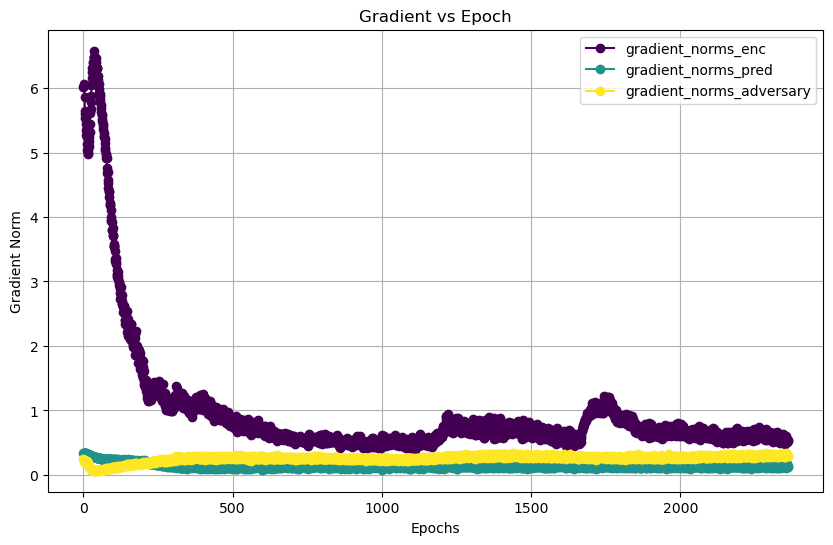

In [865]:
# plot_lines(range(len(epochs_total)), gradient_norms_enc, gradient_norms_pred, *gradient_norms_adversaries, labels=['gradient_norms_enc', 'gradient_norms_pred', 'gradient_norms_adversary'], title='Gradient vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')
plot_lines(range(len(epochs_total)), gradient_norms_enc, gradient_norms_pred, gradient_norms_adversaryA, labels=['gradient_norms_enc', 'gradient_norms_pred', 'gradient_norms_adversary'], title='Gradient vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')

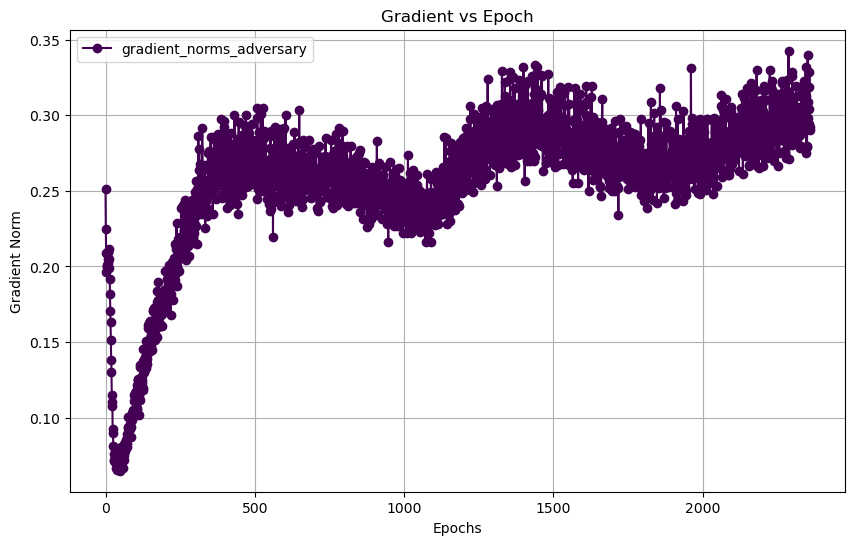

In [866]:
# plot_lines(range(len(epochs_total)), gradient_norms_enc, gradient_norms_pred, *gradient_norms_adversaries, labels=['gradient_norms_enc', 'gradient_norms_pred', 'gradient_norms_adversary'], title='Gradient vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')
plot_lines(range(len(epochs_total)), gradient_norms_adversaryA, labels=[ 'gradient_norms_adversary'], title='Gradient vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')

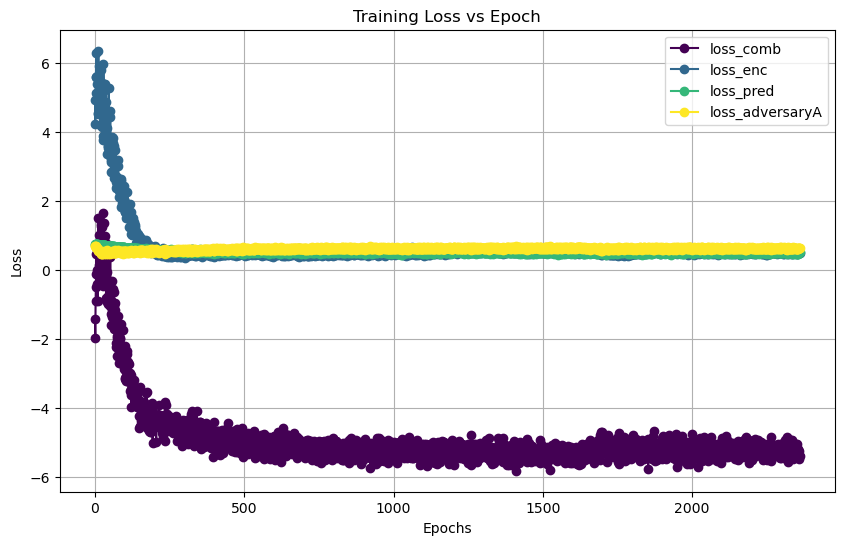

In [867]:
plot_lines(range(len(epochs_total)), loss_comb, loss_enc, loss_pred, loss_adversaryA, labels=['loss_comb', 'loss_enc', 'loss_pred', 'loss_adversaryA'], title='Training Loss vs Epoch', xlabel='Epochs', ylabel='Loss')

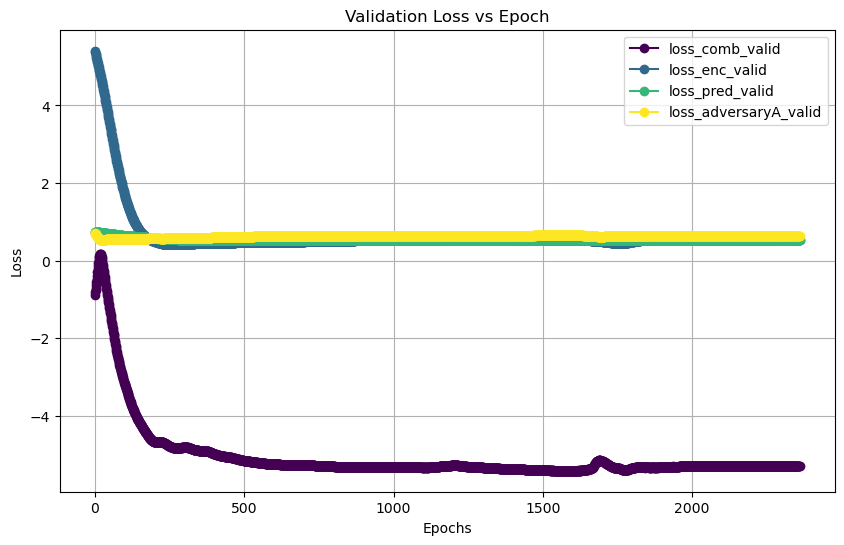

In [868]:
plot_lines(range(len(epochs_total)), loss_comb_valid, loss_enc_valid, loss_pred_valid, loss_adversaryA_valid, labels=['loss_comb_valid', 'loss_enc_valid', 'loss_pred_valid', 'loss_adversaryA_valid'], title='Validation Loss vs Epoch', xlabel='Epochs', ylabel='Loss')

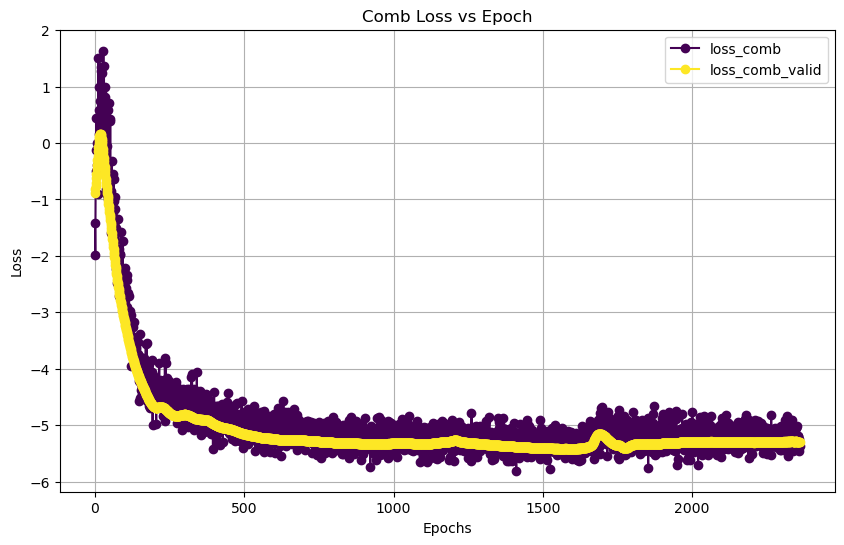

In [869]:
plot_lines(range(len(epochs_total)), loss_comb, loss_comb_valid, labels=['loss_comb', 'loss_comb_valid'], title='Comb Loss vs Epoch', xlabel='Epochs', ylabel='Loss')

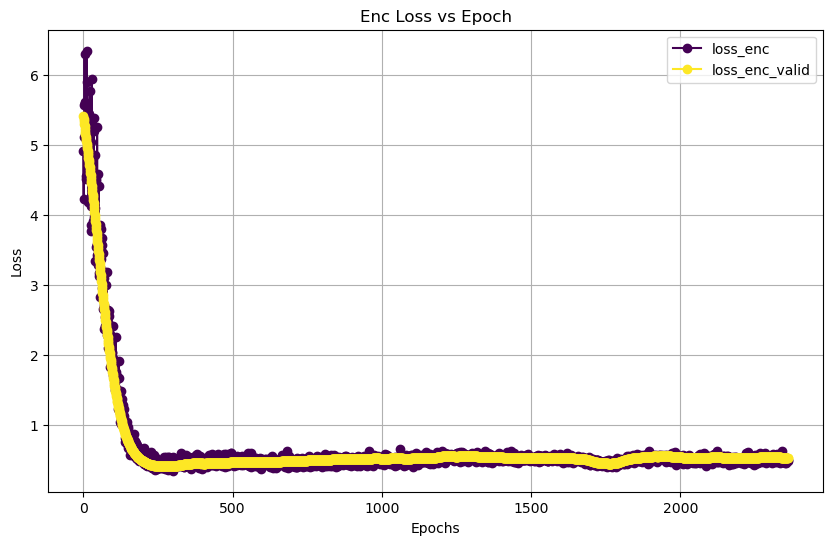

In [870]:
plot_lines(range(len(epochs_total)), loss_enc, loss_enc_valid, labels=['loss_enc', 'loss_enc_valid'], title='Enc Loss vs Epoch', xlabel='Epochs', ylabel='Loss')

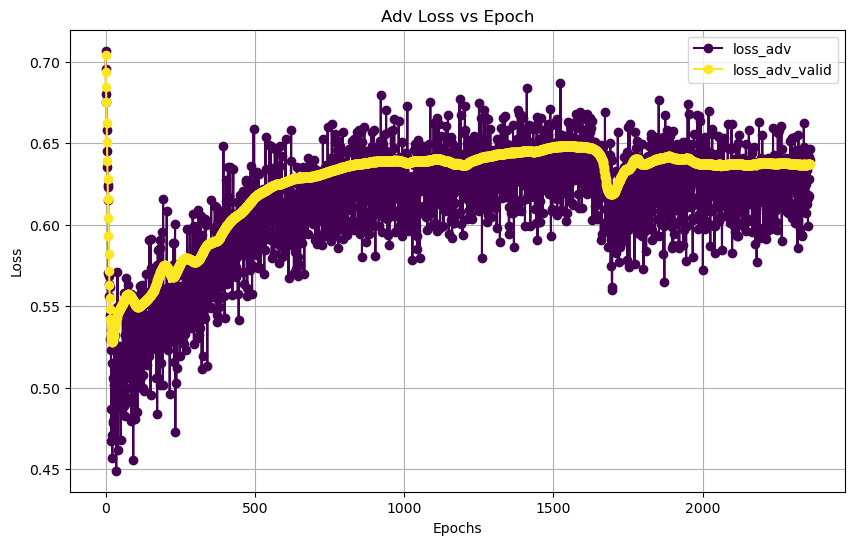

In [871]:
plot_lines(range(len(epochs_total)), loss_adversaryA, loss_adversaryA_valid, labels=['loss_adv', 'loss_adv_valid'], title='Adv Loss vs Epoch', xlabel='Epochs', ylabel='Loss')

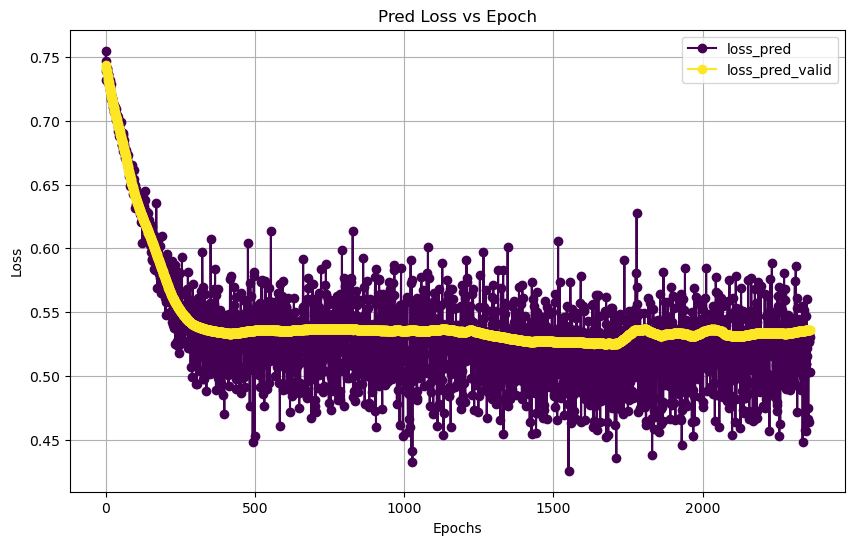

In [872]:
plot_lines(range(len(epochs_total)), loss_pred, loss_pred_valid, labels=['loss_pred', 'loss_pred_valid'], title='Pred Loss vs Epoch', xlabel='Epochs', ylabel='Loss')

In [901]:
new_df = get_transformed_features(test_loader, data_test, num_non_sensitive, num_sensitive, encoder)

In [902]:
new_df.head()

,X1,X2,X3,X4,S1,Y
0,2.628731,-2.824695,-0.275739,0.163771,0,1
1,1.552770,0.303114,0.037609,-1.145419,1,1
2,3.958846,-4.361874,0.197791,-0.853658,1,0
3,0.578983,-2.153240,-0.222837,1.247439,1,1
4,3.509727,-2.043917,0.125507,-1.695796,0,1


In [983]:
new_df.to_csv('data-nl-after.csv', index=False)

In [903]:
data_test.head()

,X1,X2,X3,X4,S1,Y
5256,2.697721,-0.802527,-0.523163,0.545369,0,1
7272,2.596345,-1.090386,-0.198627,-1.837867,1,1
1323,4.810079,-5.339294,0.061089,-1.147428,1,0
4924,1.101102,-3.851651,-0.173396,1.712606,1,1
5845,3.378662,-0.572034,0.576172,-0.362244,0,1


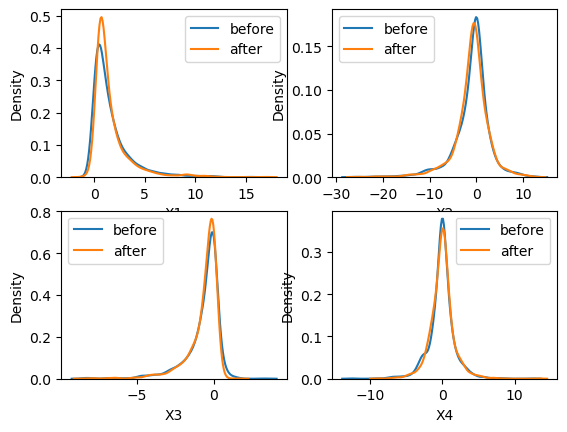

In [904]:
# _ = plt.figure()
# ax = plt.gca()

fig, ax = plt.subplots(2,2)
ax = ax.reshape(-1)

plt.subplot(2,2,1)
sns.kdeplot(data_test['X1'], ax=ax[0])
sns.kdeplot(new_df['X1'], ax=ax[0])
ax[0].legend(['before','after'])

plt.subplot(2,2,2)
sns.kdeplot(data_test['X2'], ax=ax[1])
sns.kdeplot(new_df['X2'], ax=ax[1])
ax[1].legend(['before','after'])

plt.subplot(2,2,3)
sns.kdeplot(data_test['X3'], ax=ax[2])
sns.kdeplot(new_df['X3'], ax=ax[2])
ax[2].legend(['before','after'])

plt.subplot(2,2,4)
sns.kdeplot(data_test['X4'], ax=ax[3])
sns.kdeplot(new_df['X4'], ax=ax[3])
ax[3].legend(['before','after'])

plt.show()

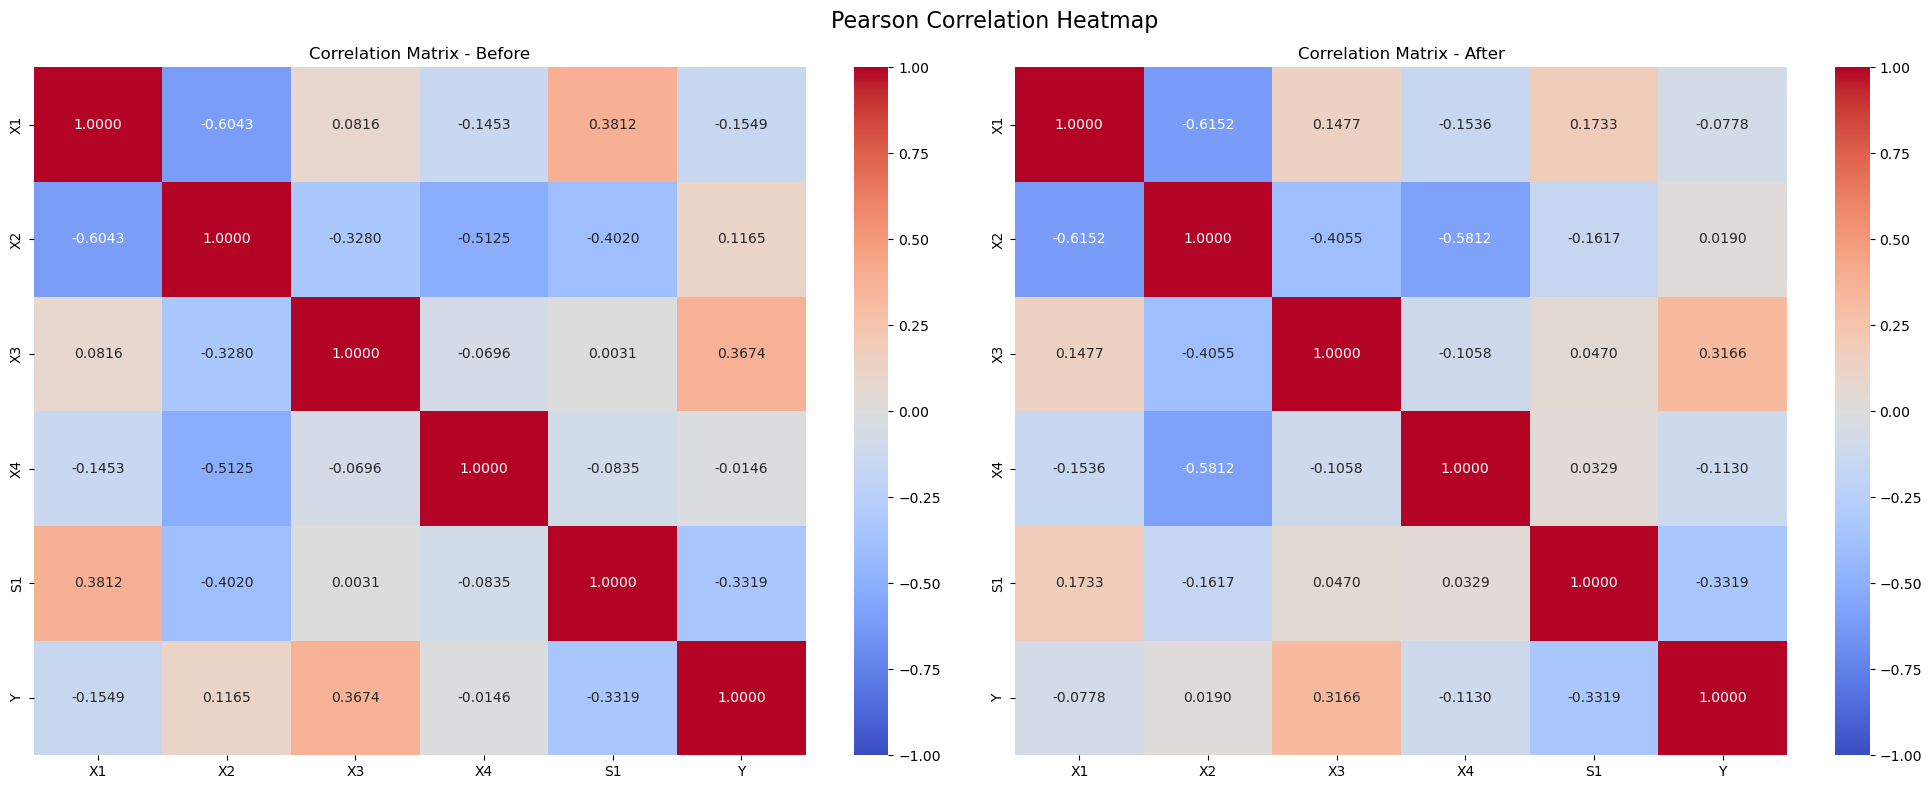

In [905]:
plot_comparison_heatmaps(data_test, new_df, figsize=(20, 8), cmap='coolwarm', vmin=-1, vmax=1)

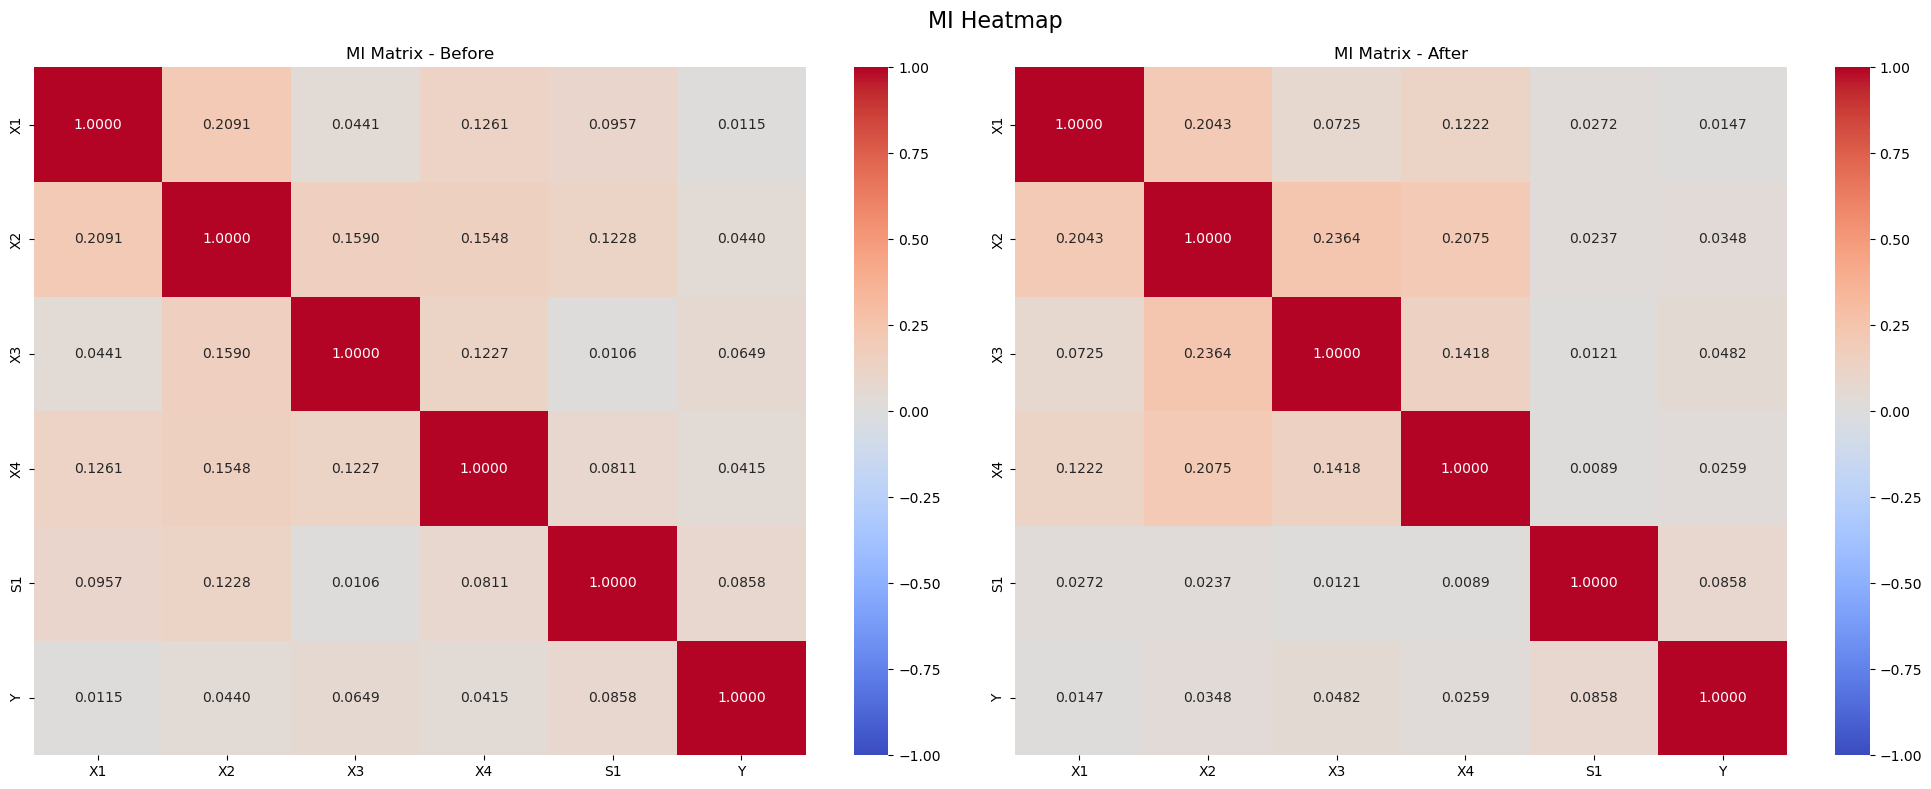

In [907]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(mutual_info_matrix(data_test), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('MI Matrix - Before')

plt.subplot(1, 2, 2)
sns.heatmap(mutual_info_matrix(new_df), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('MI Matrix - After')

plt.suptitle('MI Heatmap', fontsize=16)

plt.tight_layout()
plt.show()

In [908]:
temp = mutual_info_matrix(data_test).copy()
temp = np.array(temp)
for i in range(len(temp)):
    for j in range(len(temp[0])):
        if i==j:
            temp[i][j]=0.0

In [909]:
temp1 = mutual_info_matrix(new_df).copy()
temp1 = np.array(temp1)
for i in range(len(temp1)):
    for j in range(len(temp1[0])):
        if i==j:
            temp1[i][j]=0.0

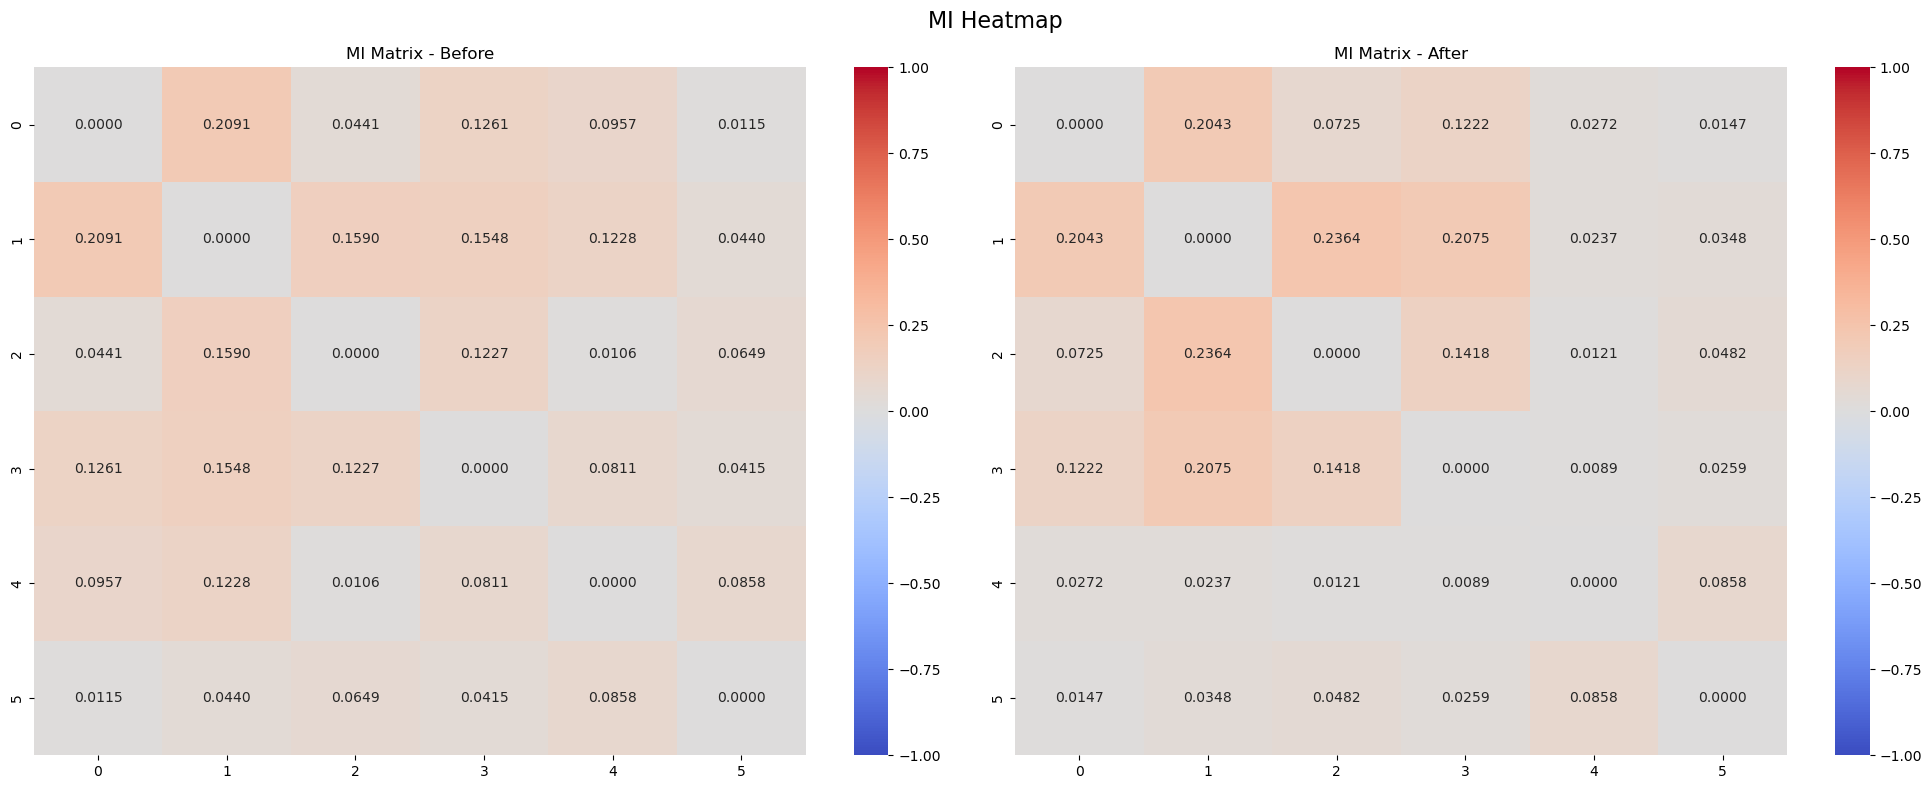

In [910]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(temp, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('MI Matrix - Before')

plt.subplot(1, 2, 2)
sns.heatmap(temp1, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('MI Matrix - After')

plt.suptitle('MI Heatmap', fontsize=16)

plt.tight_layout()
plt.show()

In [911]:
# how to minimize changed correlations between non sensitive vars
# how do we show equivalence in the linear case 
# how do we penalize distribution shifts, figure out if kl div like loss can be applied between x1 and x1'
# aggregate plot to show % improvement in dp vs % reduction in predictor performance
# try this on benchmarks datasets

In [912]:
y_true, y_logits, y_pred = get_predictions(data_test, num_non_sensitive, num_sensitive, encoder, predictor, threshold=0.5)

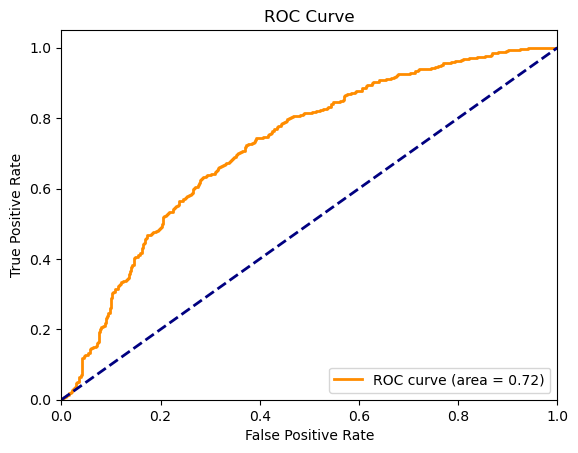

In [913]:
plot_auc_roc_curve(y_true, y_logits, title='ROC Curve')

In [914]:
np.unique(y_true, return_counts=True)

(array([0, 1]), array([ 433, 1067]))

In [915]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([ 169, 1331]))

In [916]:
metrics = evaluate_classifier(y_true, y_pred, y_logits)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.7427
Precision: 0.7558
Recall: 0.9428
F1 Score: 0.8390
ROC AUC Score: 0.7229


In [917]:
all_group_stats, all_demographic_parity = get_demographic_parity(y_true, y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 924                   836                  0.904762
1                 576                   495                  0.859375



Demographic parity for sensitive variable: S1
0.04538690476190477


In [929]:
new_df_train, new_df_test = perform_train_test_split(new_df, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, test_size=0.2,random_state=69)

print(new_df_train.shape, new_df_test.shape)

(1200, 6) (300, 6)


In [930]:
X_train, Y_train = new_df_train[['X1', 'X2', 'X3', 'X4']], new_df_train[['Y']]
X_test, Y_test = new_df_test[['X1', 'X2', 'X3', 'X4']], new_df_test[['Y']]
model_after = train_xgb_classifier(X_train, Y_train, seed=69)

Y_pred = model_after.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_after.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:29:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


0.6838489802438894


In [942]:
import optuna
from fairness.xgb_optuna import objective
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, X_test, Y_train, Y_test), n_trials=100)

[I 2024-11-27 16:33:41,258] A new study created in memory with name: no-name-fee2cd6d-96d3-424c-b8b7-d61425b3fd18
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  '

Trial 0:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.015095954707748016, 'n_estimators': 459, 'subsample': 0.7217483329375503, 'colsample_bytree': 0.8087022159752002, 'gamma': 0.019172206383187063, 'min_child_weight': 1}
Accuracy: 0.7133333333333334, Precision: 0.7551020408163265, Recall: 0.8767772511848341, F1-score: 0.8114035087719298, AUC: 0.7276212790883434
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 1:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.03739792097096861, 'n_estimators': 300, 'subsample': 0.9786122627235732, 'colsample_bytree': 0.8648686498762638, 'gamma': 0.4420919095045896, 'min_child_weight': 9}
Accuracy: 0.73, Precision: 0.7663934426229508, Recall: 0.8862559241706162, F1-score: 0.8219780219780219, AUC: 0.7328931252995368
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 2:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.17161434639376388, 'n_estimators': 293, 'subsample': 0.9074839165970972, 'colsample_bytree': 0.7978189579446082, 'gamma': 0.4600754540735331, 'min_child_weight': 6}
Accuracy: 0.7033333333333334, Precision: 0.7652173913043478, Recall: 0.8341232227488151, F1-score: 0.7981859410430839, AUC: 0.7078119175674956
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 3:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.07425897900828542, 'n_estimators': 453, 'subsample': 0.7411157744016079, 'colsample_bytree': 0.8067180782524267, 'gamma': 0.07328468499642676, 'min_child_weight': 6}
Accuracy: 0.7066666666666667, Precision: 0.7617021276595745, Recall: 0.8483412322274881, F1-score: 0.8026905829596412, AUC: 0.7244794717503595
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 4:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.04283090623527237, 'n_estimators': 410, 'subsample': 0.7087321070695922, 'colsample_bytree': 0.8097855371336442, 'gamma': 0.3940216822467659, 'min_child_weight': 9}
Accuracy: 0.74, Precision: 0.7714285714285715, Recall: 0.8957345971563981, F1-score: 0.8289473684210527, AUC: 0.7284732946376271
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 5:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.07868172162089297, 'n_estimators': 499, 'subsample': 0.7692988204130239, 'colsample_bytree': 0.705325179010183, 'gamma': 0.4701349209066581, 'min_child_weight': 4}
Accuracy: 0.6933333333333334, Precision: 0.7531914893617021, Recall: 0.8388625592417062, F1-score: 0.7937219730941704, AUC: 0.7065338942435699
--------------------------------------------------
Trial 6:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.2516820215477208, 'n_estimators': 104, 'subsample': 0.9476794839950531, 'colsample_bytree': 0.7869758879379356, 'gamma': 0.3861913704288345, 'min_child_weight': 10}
Accuracy: 0.7333333333333333, Precision: 0.7717842323651453, Recall: 0.8815165876777251, F1-score: 0.8230088495575221, AUC: 0.7411470259332233
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 7:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09981398866823939, 'n_estimators': 471, 'subsample': 0.940138190717853, 'colsample_bytree': 0.7909441925274954, 'gamma': 0.21303735609701402, 'min_child_weight': 4}
Accuracy: 0.7066666666666667, Precision: 0.7662337662337663, Recall: 0.8388625592417062, F1-score: 0.8009049773755657, AUC: 0.7099952074125353
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 8:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.0163476239071344, 'n_estimators': 322, 'subsample': 0.9274446568769772, 'colsample_bytree': 0.8855936927040469, 'gamma': 0.3019257129728279, 'min_child_weight': 3}
Accuracy: 0.7266666666666667, Precision: 0.7590361445783133, Recall: 0.8957345971563981, F1-score: 0.8217391304347826, AUC: 0.7300974492784494
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 9:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09322131524538216, 'n_estimators': 337, 'subsample': 0.8787594210393557, 'colsample_bytree': 0.8951896975668314, 'gamma': 0.09194872659111608, 'min_child_weight': 1}
Accuracy: 0.7066666666666667, Precision: 0.7685589519650655, Recall: 0.8341232227488151, F1-score: 0.8, AUC: 0.7050961180041537
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 10:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.2726473672490255, 'n_estimators': 161, 'subsample': 0.8367171253577785, 'colsample_bytree': 0.9733685432638184, 'gamma': 0.3086214061499438, 'min_child_weight': 10}
Accuracy: 0.7233333333333334, Precision: 0.7758620689655172, Recall: 0.8530805687203792, F1-score: 0.8126410835214447, AUC: 0.7239469620320571
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 11:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.030652480393579384, 'n_estimators': 188, 'subsample': 0.993074436271838, 'colsample_bytree': 0.7101945589559387, 'gamma': 0.37959846427799704, 'min_child_weight': 8}
Accuracy: 0.7333333333333333, Precision: 0.7609561752988048, Recall: 0.9052132701421801, F1-score: 0.8268398268398268, AUC: 0.7281537888066457
--------------------------------------------------
Trial 12:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.028522282327469225, 'n_estimators': 116, 'subsample': 0.9768384439981026, 'colsample_bytree': 0.8753819208202794, 'gamma': 0.40155978514031326, 'min_child_weight': 8}
Accuracy: 0.7266666666666667, Precision: 0.7569721115537849, Recall: 0.9004739336492891, F1-score: 0.8225108225108225, AUC: 0.7370999520741254
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 13:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.02634195447086926, 'n_estimators': 117, 'subsample': 0.8407728351885522, 'colsample_bytree': 0.9409832882462911, 'gamma': 0.20207490781715337, 'min_child_weight': 8}
Accuracy: 0.7366666666666667, Precision: 0.7619047619047619, Recall: 0.909952606635071, F1-score: 0.8293736501079914, AUC: 0.7389104851163534
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 14:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.010065092040339712, 'n_estimators': 220, 'subsample': 0.8265809818064058, 'colsample_bytree': 0.9829010466976931, 'gamma': 0.20955006773419338, 'min_child_weight': 10}
Accuracy: 0.7366666666666667, Precision: 0.746268656716418, Recall: 0.9478672985781991, F1-score: 0.8350730688935282, AUC: 0.7342510250812078
--------------------------------------------------
Trial 15:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.2964655909325306, 'n_estimators': 107, 'subsample': 0.7935530010034864, 'colsample_bytree': 0.9232684699029768, 'gamma': 0.15302157149592172, 'min_child_weight': 7}
Accuracy: 0.71, Precision: 0.7695652173913043, Recall: 0.8388625592417062, F1-score: 0.8027210884353742, AUC: 0.7137760264124822
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 16:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.13832265304814528, 'n_estimators': 250, 'subsample': 0.8788388803384204, 'colsample_bytree': 0.7433335116592985, 'gamma': 0.29070891890342554, 'min_child_weight': 8}
Accuracy: 0.71, Precision: 0.7627118644067796, Recall: 0.8530805687203792, F1-score: 0.8053691275167785, AUC: 0.7113797326801213
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 17:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.02534677227340547, 'n_estimators': 157, 'subsample': 0.8089748572088984, 'colsample_bytree': 0.9314768218982156, 'gamma': 0.15177998091182082, 'min_child_weight': 10}
Accuracy: 0.75, Precision: 0.7677165354330708, Recall: 0.9241706161137441, F1-score: 0.8387096774193549, AUC: 0.734304276053038
--------------------------------------------------
Trial 18:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.05672733592121919, 'n_estimators': 100, 'subsample': 0.8764954531017547, 'colsample_bytree': 0.7562926642540668, 'gamma': 0.34656166454032195, 'min_child_weight': 7}
Accuracy: 0.73, Precision: 0.7579365079365079, Recall: 0.9052132701421801, F1-score: 0.8250539956803455, AUC: 0.7372064540177858
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 19:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.16837017069219648, 'n_estimators': 162, 'subsample': 0.9484942396461673, 'colsample_bytree': 0.949945100741225, 'gamma': 0.2509553122291639, 'min_child_weight': 9}
Accuracy: 0.7233333333333334, Precision: 0.7666666666666667, Recall: 0.8720379146919431, F1-score: 0.8159645232815964, AUC: 0.7222429309334896
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 20:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.018718647144057715, 'n_estimators': 230, 'subsample': 0.8566060617324969, 'colsample_bytree': 0.8272605231243255, 'gamma': 0.18237204354926978, 'min_child_weight': 7}
Accuracy: 0.7366666666666667, Precision: 0.7619047619047619, Recall: 0.909952606635071, F1-score: 0.8293736501079914, AUC: 0.7374194579051067
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 21:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.018923345574130376, 'n_estimators': 244, 'subsample': 0.8543189328826764, 'colsample_bytree': 0.8377222251636931, 'gamma': 0.15173765479012047, 'min_child_weight': 7}
Accuracy: 0.7366666666666667, Precision: 0.7598425196850394, Recall: 0.9146919431279621, F1-score: 0.8301075268817204, AUC: 0.7389903615740987
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 22:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01020458785033501, 'n_estimators': 137, 'subsample': 0.9108470882436449, 'colsample_bytree': 0.8343602604744211, 'gamma': 0.11201491473380197, 'min_child_weight': 5}
Accuracy: 0.7366666666666667, Precision: 0.737410071942446, Recall: 0.9715639810426541, F1-score: 0.8384458077709611, AUC: 0.7266095106235689
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 23:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01991452180238392, 'n_estimators': 205, 'subsample': 0.7836669418362504, 'colsample_bytree': 0.8454487042489286, 'gamma': 0.2566181580684942, 'min_child_weight': 9}
Accuracy: 0.7366666666666667, Precision: 0.7661290322580645, Recall: 0.9004739336492891, F1-score: 0.8278867102396514, AUC: 0.736780446243144
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 24:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.04995603791174088, 'n_estimators': 256, 'subsample': 0.8550321389480751, 'colsample_bytree': 0.9079745741869748, 'gamma': 0.03273121455659772, 'min_child_weight': 8}
Accuracy: 0.73, Precision: 0.7663934426229508, Recall: 0.8862559241706162, F1-score: 0.8219780219780219, AUC: 0.7369934501304648
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 25:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.02312885365749966, 'n_estimators': 375, 'subsample': 0.7514859268677667, 'colsample_bytree': 0.7718794833512608, 'gamma': 0.15094131675388367, 'min_child_weight': 7}
Accuracy: 0.7366666666666667, Precision: 0.764, Recall: 0.9052132701421801, F1-score: 0.8286334056399133, AUC: 0.7295383140742319
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 26:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.012967637906638237, 'n_estimators': 183, 'subsample': 0.907231772248281, 'colsample_bytree': 0.8559420434991933, 'gamma': 0.21162326357773195, 'min_child_weight': 10}
Accuracy: 0.7266666666666667, Precision: 0.7471264367816092, Recall: 0.9241706161137441, F1-score: 0.826271186440678, AUC: 0.7380318440811544
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 27:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.033342580187735074, 'n_estimators': 132, 'subsample': 0.8100632902324613, 'colsample_bytree': 0.7402641444187539, 'gamma': 0.33715567241156574, 'min_child_weight': 6}
Accuracy: 0.7366666666666667, Precision: 0.7538461538461538, Recall: 0.9289099526066351, F1-score: 0.832271762208068, AUC: 0.7340380211938868
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 28:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.05955204258161845, 'n_estimators': 258, 'subsample': 0.8336776575488122, 'colsample_bytree': 0.7730440663850795, 'gamma': 0.12303192851945495, 'min_child_weight': 5}
Accuracy: 0.72, Precision: 0.7613168724279835, Recall: 0.8767772511848341, F1-score: 0.8149779735682819, AUC: 0.7203258959476011
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 29:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.013754785597830806, 'n_estimators': 136, 'subsample': 0.9576408957287974, 'colsample_bytree': 0.9975457658209038, 'gamma': 0.06653123926082244, 'min_child_weight': 9}
Accuracy: 0.73, Precision: 0.75, Recall: 0.9241706161137441, F1-score: 0.8280254777070064, AUC: 0.7420256669684222
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 30:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.013363730822308986, 'n_estimators': 140, 'subsample': 0.9460542121770423, 'colsample_bytree': 0.8420981552274562, 'gamma': 0.0034126860001195136, 'min_child_weight': 9}
Accuracy: 0.74, Precision: 0.752851711026616, Recall: 0.9383886255924171, F1-score: 0.8354430379746836, AUC: 0.744475211672613
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 31:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.01427611710942612, 'n_estimators': 155, 'subsample': 0.9583775591773797, 'colsample_bytree': 0.8190746280791115, 'gamma': 0.0019735975838748587, 'min_child_weight': 9}
Accuracy: 0.7366666666666667, Precision: 0.7598425196850394, Recall: 0.9146919431279621, F1-score: 0.8301075268817204, AUC: 0.744661590074019
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 32:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.01418867315129701, 'n_estimators': 140, 'subsample': 0.962076548429633, 'colsample_bytree': 0.8160966727707799, 'gamma': 0.00945949709721152, 'min_child_weight': 9}
Accuracy: 0.7333333333333333, Precision: 0.752895752895753, Recall: 0.9241706161137441, F1-score: 0.8297872340425532, AUC: 0.741067149475478
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 33:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.012209862941975793, 'n_estimators': 176, 'subsample': 0.9593839729727281, 'colsample_bytree': 0.78132380448169, 'gamma': 0.04309037157733371, 'min_child_weight': 9}
Accuracy: 0.73, Precision: 0.75390625, Recall: 0.9146919431279621, F1-score: 0.8265524625267666, AUC: 0.7417860375951861
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 34:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.012451453368745235, 'n_estimators': 187, 'subsample': 0.989978134890801, 'colsample_bytree': 0.9948559540341742, 'gamma': 0.0514336283062483, 'min_child_weight': 9}
Accuracy: 0.7333333333333333, Precision: 0.758893280632411, Recall: 0.909952606635071, F1-score: 0.8275862068965517, AUC: 0.741067149475478
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 35:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.015551607230347833, 'n_estimators': 286, 'subsample': 0.9251200183681002, 'colsample_bytree': 0.8517789369594319, 'gamma': 0.005420136063246726, 'min_child_weight': 9}
Accuracy: 0.73, Precision: 0.76, Recall: 0.9004739336492891, F1-score: 0.824295010845987, AUC: 0.7387507322008626
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 36:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.011396332605007511, 'n_estimators': 165, 'subsample': 0.9703550631304342, 'colsample_bytree': 0.8142559977079702, 'gamma': 0.05593553601130477, 'min_child_weight': 8}
Accuracy: 0.7266666666666667, Precision: 0.7529411764705882, Recall: 0.909952606635071, F1-score: 0.8240343347639485, AUC: 0.7411204004473082
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 37:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.015976667013713766, 'n_estimators': 206, 'subsample': 0.9631614874424322, 'colsample_bytree': 0.8683081068165119, 'gamma': 0.03852877202288675, 'min_child_weight': 10}
Accuracy: 0.74, Precision: 0.7628458498023716, Recall: 0.9146919431279621, F1-score: 0.8318965517241379, AUC: 0.7410405239895629
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 38:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.021346813477629453, 'n_estimators': 139, 'subsample': 0.9000077941900407, 'colsample_bytree': 0.7975863788278164, 'gamma': 0.07955219216822873, 'min_child_weight': 9}
Accuracy: 0.7333333333333333, Precision: 0.7609561752988048, Recall: 0.9052132701421801, F1-score: 0.8268398268398268, AUC: 0.7434634432078385
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 39:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.038324810791581405, 'n_estimators': 140, 'subsample': 0.896729435867306, 'colsample_bytree': 0.8000375845763397, 'gamma': 0.08219254567586642, 'min_child_weight': 2}
Accuracy: 0.7233333333333334, Precision: 0.7601626016260162, Recall: 0.8862559241706162, F1-score: 0.8183807439824945, AUC: 0.7324671175248949
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 40:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.021826019128571097, 'n_estimators': 132, 'subsample': 0.9267302557004664, 'colsample_bytree': 0.8230591842447147, 'gamma': 0.07325650855327645, 'min_child_weight': 8}
Accuracy: 0.7333333333333333, Precision: 0.7609561752988048, Recall: 0.9052132701421801, F1-score: 0.8268398268398268, AUC: 0.7419457905106768
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 41:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.02129565836410882, 'n_estimators': 132, 'subsample': 0.926267203639338, 'colsample_bytree': 0.822984871896631, 'gamma': 0.07497604918665128, 'min_child_weight': 9}
Accuracy: 0.7333333333333333, Precision: 0.758893280632411, Recall: 0.909952606635071, F1-score: 0.8275862068965517, AUC: 0.7438362000106501
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 42:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0177241854140483, 'n_estimators': 152, 'subsample': 0.9418439482086179, 'colsample_bytree': 0.8031101531360935, 'gamma': 0.0036270103434326694, 'min_child_weight': 9}
Accuracy: 0.7366666666666667, Precision: 0.7598425196850394, Recall: 0.9146919431279621, F1-score: 0.8301075268817204, AUC: 0.7405612652430906
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 43:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.014336762090812069, 'n_estimators': 122, 'subsample': 0.8942020940023999, 'colsample_bytree': 0.8568688518586802, 'gamma': 0.09505897473898729, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7537878787878788, Recall: 0.943127962085308, F1-score: 0.8378947368421052, AUC: 0.7439427019543108
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 44:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.02168978922672685, 'n_estimators': 120, 'subsample': 0.8863469723322775, 'colsample_bytree': 0.8643932742526875, 'gamma': 0.10364401197378223, 'min_child_weight': 10}
Accuracy: 0.7366666666666667, Precision: 0.7598425196850394, Recall: 0.9146919431279621, F1-score: 0.8301075268817204, AUC: 0.7432504393205176
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 45:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.01657225495392093, 'n_estimators': 416, 'subsample': 0.9087607086487395, 'colsample_bytree': 0.8796375296141884, 'gamma': 0.02533745690863251, 'min_child_weight': 10}
Accuracy: 0.7333333333333333, Precision: 0.7695473251028807, Recall: 0.8862559241706162, F1-score: 0.8237885462555066, AUC: 0.7343841525107833
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 46:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.03424616961900552, 'n_estimators': 209, 'subsample': 0.9295032062564713, 'colsample_bytree': 0.847959423933318, 'gamma': 0.12619004577675788, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7701612903225806, Recall: 0.9052132701421801, F1-score: 0.8322440087145969, AUC: 0.7406677671867512
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 47:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.025448847042329702, 'n_estimators': 176, 'subsample': 0.8966216044064768, 'colsample_bytree': 0.787982297538394, 'gamma': 0.08991783598122904, 'min_child_weight': 9}
Accuracy: 0.73, Precision: 0.76, Recall: 0.9004739336492891, F1-score: 0.824295010845987, AUC: 0.7336386389051599
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 48:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.01131956146707935, 'n_estimators': 118, 'subsample': 0.9991545317603528, 'colsample_bytree': 0.8955968628978621, 'gamma': 0.06407228480821019, 'min_child_weight': 8}
Accuracy: 0.75, Precision: 0.753731343283582, Recall: 0.957345971563981, F1-score: 0.8434237995824635, AUC: 0.7467117524894828
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 49:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.011110348347612875, 'n_estimators': 117, 'subsample': 0.9887198960449506, 'colsample_bytree': 0.8958836156562183, 'gamma': 0.02264542370239673, 'min_child_weight': 8}
Accuracy: 0.7433333333333333, Precision: 0.75, Recall: 0.95260663507109, F1-score: 0.8392484342379958, AUC: 0.7423717982853189
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 50:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.014231035696287628, 'n_estimators': 106, 'subsample': 0.9804132064881731, 'colsample_bytree': 0.902928193324352, 'gamma': 0.05472937636678699, 'min_child_weight': 6}
Accuracy: 0.7333333333333333, Precision: 0.7471698113207547, Recall: 0.9383886255924171, F1-score: 0.8319327731092437, AUC: 0.7319878587784228
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 51:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.01006229188062471, 'n_estimators': 152, 'subsample': 0.9345638529463983, 'colsample_bytree': 0.8360732402608502, 'gamma': 0.0755835460414111, 'min_child_weight': 9}
Accuracy: 0.7366666666666667, Precision: 0.7481203007518797, Recall: 0.943127962085308, F1-score: 0.8343815513626834, AUC: 0.7445284626444433
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 52:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010879771697585713, 'n_estimators': 153, 'subsample': 0.9472379815665053, 'colsample_bytree': 0.8610671914286991, 'gamma': 0.025632969275140707, 'min_child_weight': 8}
Accuracy: 0.7466666666666667, Precision: 0.7586206896551724, Recall: 0.9383886255924171, F1-score: 0.8389830508474576, AUC: 0.7442089568134619
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 53:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010327237781207385, 'n_estimators': 159, 'subsample': 0.9993678832346166, 'colsample_bytree': 0.8654467765907282, 'gamma': 0.024325857370945156, 'min_child_weight': 8}
Accuracy: 0.75, Precision: 0.7595419847328244, Recall: 0.943127962085308, F1-score: 0.8414376321353065, AUC: 0.7453272272218967
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 54:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010026052701425895, 'n_estimators': 159, 'subsample': 0.9969198335881001, 'colsample_bytree': 0.8726372941228456, 'gamma': 0.020878016975989757, 'min_child_weight': 8}
Accuracy: 0.75, Precision: 0.7575757575757576, Recall: 0.9478672985781991, F1-score: 0.8421052631578947, AUC: 0.7432770648064326
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 55:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.011468806391246613, 'n_estimators': 195, 'subsample': 0.9754731054905628, 'colsample_bytree': 0.8856985972438065, 'gamma': 0.0025160686203434877, 'min_child_weight': 7}
Accuracy: 0.7233333333333334, Precision: 0.7580645161290323, Recall: 0.8909952606635071, F1-score: 0.8191721132897604, AUC: 0.7373395814473614
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 56:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.012471220543216515, 'n_estimators': 173, 'subsample': 0.9480213553515344, 'colsample_bytree': 0.8403466527703102, 'gamma': 0.03390216820705574, 'min_child_weight': 8}
Accuracy: 0.7333333333333333, Precision: 0.7568627450980392, Recall: 0.9146919431279621, F1-score: 0.8283261802575107, AUC: 0.7421321689120828
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 57:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010801857902330096, 'n_estimators': 149, 'subsample': 0.9838667568869366, 'colsample_bytree': 0.9114115817189897, 'gamma': 0.44709190535364096, 'min_child_weight': 6}
Accuracy: 0.73, Precision: 0.75390625, Recall: 0.9146919431279621, F1-score: 0.8265524625267666, AUC: 0.7312423451727994
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 58:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.017207259543566944, 'n_estimators': 221, 'subsample': 0.9691920556069351, 'colsample_bytree': 0.8892304250096539, 'gamma': 0.04262740525126013, 'min_child_weight': 7}
Accuracy: 0.7166666666666667, Precision: 0.7540322580645161, Recall: 0.8862559241706162, F1-score: 0.8148148148148148, AUC: 0.734570530912189
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 59:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.012710925935606571, 'n_estimators': 102, 'subsample': 0.939980677682771, 'colsample_bytree': 0.8315885019003445, 'gamma': 0.01877178632221196, 'min_child_weight': 8}
Accuracy: 0.74, Precision: 0.7418181818181818, Recall: 0.966824644549763, F1-score: 0.8395061728395061, AUC: 0.7434368177219236
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 60:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.01008199696385287, 'n_estimators': 197, 'subsample': 0.7024217170713292, 'colsample_bytree': 0.8740557490534294, 'gamma': 0.4828418995540855, 'min_child_weight': 4}
Accuracy: 0.7333333333333333, Precision: 0.7568627450980392, Recall: 0.9146919431279621, F1-score: 0.8283261802575107, AUC: 0.7268225145108898
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 61:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.014917267145279656, 'n_estimators': 120, 'subsample': 0.9402845030767634, 'colsample_bytree': 0.8591534997513648, 'gamma': 0.10607235708157556, 'min_child_weight': 10}
Accuracy: 0.7333333333333333, Precision: 0.7490494296577946, Recall: 0.933649289099526, F1-score: 0.8312236286919831, AUC: 0.7439959529261408
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 62:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.015332827653235638, 'n_estimators': 154, 'subsample': 0.9521201707499941, 'colsample_bytree': 0.8619157202003493, 'gamma': 0.06615108487940938, 'min_child_weight': 8}
Accuracy: 0.7233333333333334, Precision: 0.7519685039370079, Recall: 0.9052132701421801, F1-score: 0.821505376344086, AUC: 0.7419724159965919
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 63:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.011489020788136456, 'n_estimators': 167, 'subsample': 0.9971073086305097, 'colsample_bytree': 0.8435051118506368, 'gamma': 0.1201663260781784, 'min_child_weight': 9}
Accuracy: 0.7366666666666667, Precision: 0.7578125, Recall: 0.919431279620853, F1-score: 0.8308351177730193, AUC: 0.7444219607007828
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 64:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0116771179068308, 'n_estimators': 170, 'subsample': 0.998140776322395, 'colsample_bytree': 0.846737297010361, 'gamma': 0.05674371454635904, 'min_child_weight': 9}
Accuracy: 0.7333333333333333, Precision: 0.7568627450980392, Recall: 0.9146919431279621, F1-score: 0.8283261802575107, AUC: 0.7434101922360083
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 65:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.11496676614892318, 'n_estimators': 275, 'subsample': 0.9787321142840165, 'colsample_bytree': 0.8149432747227189, 'gamma': 0.12876506512180286, 'min_child_weight': 8}
Accuracy: 0.7266666666666667, Precision: 0.7721518987341772, Recall: 0.8672985781990521, F1-score: 0.8169642857142857, AUC: 0.7237339581447362
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 66:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.013504611270809756, 'n_estimators': 148, 'subsample': 0.984008019205269, 'colsample_bytree': 0.9158682264822828, 'gamma': 0.17443701012039042, 'min_child_weight': 7}
Accuracy: 0.7233333333333334, Precision: 0.753968253968254, Recall: 0.9004739336492891, F1-score: 0.8207343412526998, AUC: 0.7388838596304381
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 67:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.011044098303297745, 'n_estimators': 230, 'subsample': 0.9984118391362969, 'colsample_bytree': 0.8352077686761549, 'gamma': 0.032377321399442445, 'min_child_weight': 9}
Accuracy: 0.73, Precision: 0.7579365079365079, Recall: 0.9052132701421801, F1-score: 0.8250539956803455, AUC: 0.7402417594121092
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 68:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.013160639239147726, 'n_estimators': 350, 'subsample': 0.9689212899600672, 'colsample_bytree': 0.8967167549356815, 'gamma': 0.01892515695737859, 'min_child_weight': 8}
Accuracy: 0.7333333333333333, Precision: 0.7630522088353414, Recall: 0.9004739336492891, F1-score: 0.8260869565217391, AUC: 0.7364076894403323
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 69:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.20240173990485402, 'n_estimators': 312, 'subsample': 0.9562670597936247, 'colsample_bytree': 0.8419501398016782, 'gamma': 0.04593786708242216, 'min_child_weight': 9}
Accuracy: 0.7366666666666667, Precision: 0.7844827586206896, Recall: 0.8625592417061612, F1-score: 0.8216704288939052, AUC: 0.7159593162575217
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 70:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.01818386073778242, 'n_estimators': 181, 'subsample': 0.9193447920138853, 'colsample_bytree': 0.88109157604247, 'gamma': 0.06351530565190294, 'min_child_weight': 8}
Accuracy: 0.73, Precision: 0.76, Recall: 0.9004739336492891, F1-score: 0.824295010845987, AUC: 0.7410138985036476
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 71:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.014911594791745916, 'n_estimators': 125, 'subsample': 0.9369093153289519, 'colsample_bytree': 0.857908525386536, 'gamma': 0.1099194463843623, 'min_child_weight': 10}
Accuracy: 0.74, Precision: 0.752851711026616, Recall: 0.9383886255924171, F1-score: 0.8354430379746836, AUC: 0.7434368177219233
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 72:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.012236767209247566, 'n_estimators': 109, 'subsample': 0.9889253713129478, 'colsample_bytree': 0.8678339401544821, 'gamma': 0.09944391778759787, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7427536231884058, Recall: 0.9715639810426541, F1-score: 0.8418891170431212, AUC: 0.745380478193727
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 73:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.012349695285122888, 'n_estimators': 162, 'subsample': 0.9872937790548348, 'colsample_bytree': 0.825190465797463, 'gamma': 0.13713717366028166, 'min_child_weight': 10}
Accuracy: 0.7333333333333333, Precision: 0.752895752895753, Recall: 0.9241706161137441, F1-score: 0.8297872340425532, AUC: 0.7426114276585548
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 74:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010026232182072133, 'n_estimators': 112, 'subsample': 0.9724762157114877, 'colsample_bytree': 0.8681584127510628, 'gamma': 6.502216249925155e-05, 'min_child_weight': 9}
Accuracy: 0.74, Precision: 0.7383512544802867, Recall: 0.976303317535545, F1-score: 0.8408163265306122, AUC: 0.7455668565951329
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 75:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0722692022498269, 'n_estimators': 110, 'subsample': 0.97252977305025, 'colsample_bytree': 0.8731747285536372, 'gamma': 0.09009070250207638, 'min_child_weight': 9}
Accuracy: 0.7333333333333333, Precision: 0.7673469387755102, Recall: 0.8909952606635071, F1-score: 0.8245614035087719, AUC: 0.7343575270248683
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 76:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010154388060287766, 'n_estimators': 111, 'subsample': 0.999876019512745, 'colsample_bytree': 0.8069436457220996, 'gamma': 0.00020089108226423028, 'min_child_weight': 9}
Accuracy: 0.74, Precision: 0.7383512544802867, Recall: 0.976303317535545, F1-score: 0.8408163265306122, AUC: 0.7487885403908622
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 77:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010513833783161045, 'n_estimators': 100, 'subsample': 0.9910874185170911, 'colsample_bytree': 0.80692190756552, 'gamma': 0.0009542782217582866, 'min_child_weight': 3}
Accuracy: 0.7433333333333333, Precision: 0.7445255474452555, Recall: 0.966824644549763, F1-score: 0.8412371134020619, AUC: 0.7228020661377069
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 78:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.010008572677267605, 'n_estimators': 130, 'subsample': 0.9618833100020816, 'colsample_bytree': 0.920296690343294, 'gamma': 0.008115548692603815, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7427536231884058, Recall: 0.9715639810426541, F1-score: 0.8418891170431212, AUC: 0.7459662388838597
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 79:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0100386070393852, 'n_estimators': 128, 'subsample': 0.9649891948485767, 'colsample_bytree': 0.9506121834412691, 'gamma': 0.014832532083302909, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7427536231884058, Recall: 0.9715639810426541, F1-score: 0.8418891170431212, AUC: 0.7466585015176528
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 80:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.011838600959566768, 'n_estimators': 127, 'subsample': 0.7240696319812382, 'colsample_bytree': 0.9530110206403261, 'gamma': 0.014470773648250843, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7445255474452555, Recall: 0.966824644549763, F1-score: 0.8412371134020619, AUC: 0.7419990414825071
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 81:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.01001154270096832, 'n_estimators': 108, 'subsample': 0.9632923503494709, 'colsample_bytree': 0.9355810339479408, 'gamma': 0.23434902131060698, 'min_child_weight': 10}
Accuracy: 0.7366666666666667, Precision: 0.737410071942446, Recall: 0.9715639810426541, F1-score: 0.8384458077709611, AUC: 0.7475637680387668
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 82:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.013097398302479567, 'n_estimators': 114, 'subsample': 0.9653588180724816, 'colsample_bytree': 0.9319358837873489, 'gamma': 0.2602886649483368, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7481481481481481, Recall: 0.957345971563981, F1-score: 0.83991683991684, AUC: 0.7446615900740189
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 83:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.011965481729580327, 'n_estimators': 109, 'subsample': 0.9777864129805272, 'colsample_bytree': 0.9546347669398181, 'gamma': 0.22917603428953787, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7427536231884058, Recall: 0.9715639810426541, F1-score: 0.8418891170431212, AUC: 0.7443420842430374
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 84:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010092295202950444, 'n_estimators': 127, 'subsample': 0.9896765332078568, 'colsample_bytree': 0.9394844018986255, 'gamma': 0.03374211088806596, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7427536231884058, Recall: 0.9715639810426541, F1-score: 0.8418891170431212, AUC: 0.7450875978486606
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 85:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010947160334639449, 'n_estimators': 129, 'subsample': 0.9902910205652364, 'colsample_bytree': 0.9409770369503535, 'gamma': 0.28341102570973065, 'min_child_weight': 10}
Accuracy: 0.7466666666666667, Precision: 0.7454545454545455, Recall: 0.9715639810426541, F1-score: 0.8436213991769548, AUC: 0.7474572660951063
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 86:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.011019960513458117, 'n_estimators': 143, 'subsample': 0.9834467310089947, 'colsample_bytree': 0.965326708715768, 'gamma': 0.2757168944874711, 'min_child_weight': 10}
Accuracy: 0.7366666666666667, Precision: 0.746268656716418, Recall: 0.9478672985781991, F1-score: 0.8350730688935282, AUC: 0.7426114276585548
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 87:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.012231129413406363, 'n_estimators': 113, 'subsample': 0.9748507134444979, 'colsample_bytree': 0.9250803168736736, 'gamma': 0.32870899345451543, 'min_child_weight': 10}
Accuracy: 0.74, Precision: 0.7418181818181818, Recall: 0.966824644549763, F1-score: 0.8395061728395061, AUC: 0.7456467330528783
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 88:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.013648286475862123, 'n_estimators': 100, 'subsample': 0.9639067425460707, 'colsample_bytree': 0.9275526469182297, 'gamma': 0.36215925145047634, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7427536231884058, Recall: 0.9715639810426541, F1-score: 0.8418891170431212, AUC: 0.7464188721444166
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 89:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.016555619751044713, 'n_estimators': 488, 'subsample': 0.9634779842726866, 'colsample_bytree': 0.9277403236467786, 'gamma': 0.33171573795571535, 'min_child_weight': 10}
Accuracy: 0.74, Precision: 0.7714285714285715, Recall: 0.8957345971563981, F1-score: 0.8289473684210527, AUC: 0.7355024229192183
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 90:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.019509374585044217, 'n_estimators': 116, 'subsample': 0.9561734051692192, 'colsample_bytree': 0.9177788543708074, 'gamma': 0.3964118421981631, 'min_child_weight': 10}
Accuracy: 0.7333333333333333, Precision: 0.7568627450980392, Recall: 0.9146919431279621, F1-score: 0.8283261802575107, AUC: 0.7396293732360615
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 91:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.013361428946695399, 'n_estimators': 107, 'subsample': 0.9755586058708715, 'colsample_bytree': 0.9446730725539105, 'gamma': 0.4179260378220084, 'min_child_weight': 10}
Accuracy: 0.7466666666666667, Precision: 0.7472527472527473, Recall: 0.966824644549763, F1-score: 0.8429752066115702, AUC: 0.7447414665317643
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 92:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.012077028814977929, 'n_estimators': 132, 'subsample': 0.9716884971561826, 'colsample_bytree': 0.965233766028156, 'gamma': 0.3645561148393047, 'min_child_weight': 10}
Accuracy: 0.73, Precision: 0.7443609022556391, Recall: 0.9383886255924171, F1-score: 0.8301886792452831, AUC: 0.7435699451514991
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 93:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010858119378803452, 'n_estimators': 100, 'subsample': 0.9916759099160936, 'colsample_bytree': 0.9357322131428538, 'gamma': 0.3155713910226693, 'min_child_weight': 10}
Accuracy: 0.74, Precision: 0.7383512544802867, Recall: 0.976303317535545, F1-score: 0.8408163265306122, AUC: 0.7457798604824537
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 94:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.01076514230547334, 'n_estimators': 122, 'subsample': 0.9816899772414136, 'colsample_bytree': 0.9348155980900626, 'gamma': 0.3169576040585407, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7427536231884058, Recall: 0.9715639810426541, F1-score: 0.8418891170431212, AUC: 0.7439959529261408
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 95:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.011111415505243688, 'n_estimators': 100, 'subsample': 0.9661801160915683, 'colsample_bytree': 0.9239004294324709, 'gamma': 0.2935057322993798, 'min_child_weight': 10}
Accuracy: 0.7366666666666667, Precision: 0.737410071942446, Recall: 0.9715639810426541, F1-score: 0.8384458077709611, AUC: 0.7466052505458225
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 96:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.014112645448805129, 'n_estimators': 132, 'subsample': 0.9521580882837763, 'colsample_bytree': 0.9253926903357163, 'gamma': 0.2950614927313544, 'min_child_weight': 10}
Accuracy: 0.7366666666666667, Precision: 0.75, Recall: 0.9383886255924171, F1-score: 0.8336842105263158, AUC: 0.7437563235529049
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 97:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.011331504170605284, 'n_estimators': 100, 'subsample': 0.8686026246092283, 'colsample_bytree': 0.9457517781618445, 'gamma': 0.35989867124959596, 'min_child_weight': 10}
Accuracy: 0.74, Precision: 0.7383512544802867, Recall: 0.976303317535545, F1-score: 0.8408163265306122, AUC: 0.7489482933063529
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 98:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010951836999428767, 'n_estimators': 100, 'subsample': 0.9648069587126546, 'colsample_bytree': 0.9617868794049761, 'gamma': 0.3526511651572313, 'min_child_weight': 10}
Accuracy: 0.7366666666666667, Precision: 0.737410071942446, Recall: 0.9715639810426541, F1-score: 0.8384458077709611, AUC: 0.7470578838063796
--------------------------------------------------


/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb_optuna.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
/home/ec2-user/SageMaker/Bias/fairness/xgb

Trial 99:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04385797693149725, 'n_estimators': 101, 'subsample': 0.7614403540781587, 'colsample_bytree': 0.9609330866802525, 'gamma': 0.36092464047979594, 'min_child_weight': 10}
Accuracy: 0.74, Precision: 0.7714285714285715, Recall: 0.8957345971563981, F1-score: 0.8289473684210527, AUC: 0.7405878907290058
--------------------------------------------------


In [943]:
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.011331504170605284, 'n_estimators': 100, 'subsample': 0.8686026246092283, 'colsample_bytree': 0.9457517781618445, 'gamma': 0.35989867124959596, 'min_child_weight': 10}


In [946]:
import xgboost as xgb
model_after = xgb.XGBClassifier(**best_params, eval_metric='logloss', random_state=69)
model_after.fit(X_train, Y_train)

Y_pred = model_after.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_after.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.7461792427711806


In [947]:
metrics_after = evaluate_classifier(Y_test, Y_pred, Y_probs[:, 1])

In [948]:
all_group_stats_after, all_demographic_parity_after = get_demographic_parity(Y_test, Y_pred, new_df_test, num_sensitive)

for sensitive_var, stat in all_group_stats_after.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity_after.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 183                   173                  0.945355
1                 117                   106                  0.905983



Demographic parity for sensitive variable: S1
0.03937228527392467


In [949]:
print('XBG metrics before transformation'.upper())
for metric, value in metrics_before.items():
    print(f"{metric}: {value:.4f}")
    
print('\n\n')

print('XBG metrics after transformation'.upper())
for metric, value in metrics_after.items():
    print(f"{metric}: {value:.4f}")

XBG METRICS BEFORE TRANSFORMATION
Accuracy: 0.8100
Precision: 0.8568
Recall: 0.8800
F1 Score: 0.8682
ROC AUC Score: 0.8829



XBG METRICS AFTER TRANSFORMATION
Accuracy: 0.7333
Precision: 0.7348
Recall: 0.9716
F1 Score: 0.8367
ROC AUC Score: 0.7462


In [981]:
print('DP before transformation'.upper())
for sensitive_var, dp in all_demographic_parity_before.items():
    print(dp)

print('\n\n')

print('DP after transformation'.upper())
for sensitive_var, dp in all_demographic_parity_after.items():
    print(dp)

DP BEFORE TRANSFORMATION
0.3152732683982684



DP AFTER TRANSFORMATION
0.03937228527392467
